<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_Top3ProductosEstrella_desde2021_PrimeraSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import pandas as pd
from numpy import abs, array, mean, sqrt, where, nan, sum
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              11                   1           AC            SVE   
1              11                   1           AC            SVE   
2              11                   1           AC            SVE   
3              11                   1           AC            SVE   
4              11                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18110999                  0      2018-11-06   
1   VENTA COMPUTARIZADA          18110996                  0      2018-11-06   
2   VENTA COMPUTARIZADA          18110995                  0      2018-11-06   
3   VENTA COMPUTARIZADA          18110992                  0      2018-11-06   
4   VENTA COMPUTARIZADA          18110978                  0      2018-11-06   

             NombreProducto UnidadMedida  CantidadSalida  PesoSalida  \
0  POLLO SIN MENUDENCIA H-C           KG          0.0000      1.2415   
1                   CORAZON           KG          0.0000      0.9274   
2  POLLO SIN MENUDENCIA H-C           KG          0.0000     23.6785   
3                   CORAZON           KG          0.0000      0.8927   
4                   CORAZON           KG          0.0000      2.6700   

   MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0    15.1300         10.8580        10.8580           2.1743    FAENEADO  
1    11.5700         11.1250        11.1250           1.6625    FAENEADO  
2   288.8940         10.8580        10.8580          41.5078    FAENEADO  
3    11.1250         11.1250        11.1250           1.5984    FAENEADO  
4    33.3750         11.1250        11.1250           4.7953    FAENEADO

In [ ]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase'
              ]]

In [ ]:
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-12-2e7c75eefad5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [ ]:
# Separar los datos de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros antes del 2021 y de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (279477, 3)
desde 2021 hasta nov2023   -  (170908, 3)
noviembre 2023             -  (4370, 3)


In [ ]:
# df_noviembre.head()
# df_noviembre.tail()
# df_todo_hasta_nov

## EVALUACION

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = where(y_true != 0)
        y_true, y_pred = array(y_true)[non_zero_indices], array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, nan)
            return nan

        # Calcular MAPE solo para los valores válidos
        return mean(abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

# Creacion del objeto con los dataframes de los 3 productos


In [ ]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Cambiamos el tipo de dato de la columna 'FechaMovimiento' a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna 'FechaMovimiento'
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<ipython-input-17-ac0c5788cc2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
<ipython-input-17-ac0c5788cc2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
<ipython-input-17-ac0c5788cc2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase
276324  POLLO SIN MENUDENCIA H-C      2023-11-01    28.4088
276277  POLLO SIN MENUDENCIA H-C      2023-11-01   178.1513
276322  POLLO SIN MENUDENCIA H-C      2023-11-01    29.5925
276295  POLLO SIN MENUDENCIA H-C      2023-11-01    29.5925
276294  POLLO SIN MENUDENCIA H-C      2023-11-01    34.3273
...                          ...             ...        ...
279428  POLLO SIN MENUDENCIA H-C      2023-11-30    31.3725
279413  POLLO SIN MENUDENCIA H-C      2023-11-30    28.4088
279414  POLLO SIN MENUDENCIA H-C      2023-11-30    33.7399
279415  POLLO SIN MENUDENCIA H-C      2023-11-30    56.8176
279416  POLLO SIN MENUDENCIA H-C      2023-11-30   262.7814

[4370 rows x 3 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
dtype: object
<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase
104914  POLLO SIN MENUDENCIA H-C      2

### Seleccion de los productos top 3


In [ ]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar los nombres de los  productos con mas dias de ventas
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA', 'CORAZON',
       'RABADILLA', 'CUELLO', 'HIGADO', 'MENUDENCIA',
       'SACHET MORTADELA DE POLLO 200 GRS', 'PATE GRANDE 200G'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
                      NombreProducto  DiasDeVenta
0           POLLO SIN MENUDENCIA H-C          996
1                            PECHUGA          924
2                       PIERNA MUSLO          904
3                             CUELLO          892
4                             HIGADO          791
5                         MENUDENCIA          758
6                          RABADILLA          736
7                            CORAZON          681
8                   PATE GRANDE 200G          523
9  SACHET MORTADELA DE POLLO 200 GRS          473

Días de venta y MontoBase total para cada producto:
                      NombreProducto     MontoBase
0           POLLO SIN MENUDENCIA

<ipython-input-18-94042d1602d9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen 3 DF c/u con los productos mas vendidos

In [ ]:
#objeto que contendra los dataframes de los top 3 productos
dfs_de_productos = {}

# Iterar sobre los productos y dividir el DataFrame
for nombre_producto in top_3_productos['NombreProducto']:
    # Crear un DataFrame para el producto actual
    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    product_df.set_index('FechaMovimiento', inplace=True)

    # Almacenar el DataFrame en el diccionario
    dfs_de_productos[nombre_producto] = product_df

In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos.items():
    # Sumar las ventas por día sin perder 'NombreProducto'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado

In [ ]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 0, last_day_oct_2023]], columns=['NombreProducto', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

<ipython-input-21-634f8930b693>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-21-634f8930b693>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-21-634f8930b693>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


### Rellenar los dataset con las fechas faltantes
Rellenar las fechas faltantes con el valor del dia anterior

In [ ]:
from copy import deepcopy

In [ ]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].tail)
print(dfs_de_productos_sumados['PIERNA MUSLO'].tail)
# print(dfs_de_productos['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
MontoBase         float64
dtype: object
<bound method NDFrame.tail of                            NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  6008.0340
...                                   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 2 columns]>
<bound method NDFrame.tail of                 NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02        PIERNA MUSLO   301.0240
2021-01-03        PIERNA MUSLO   4

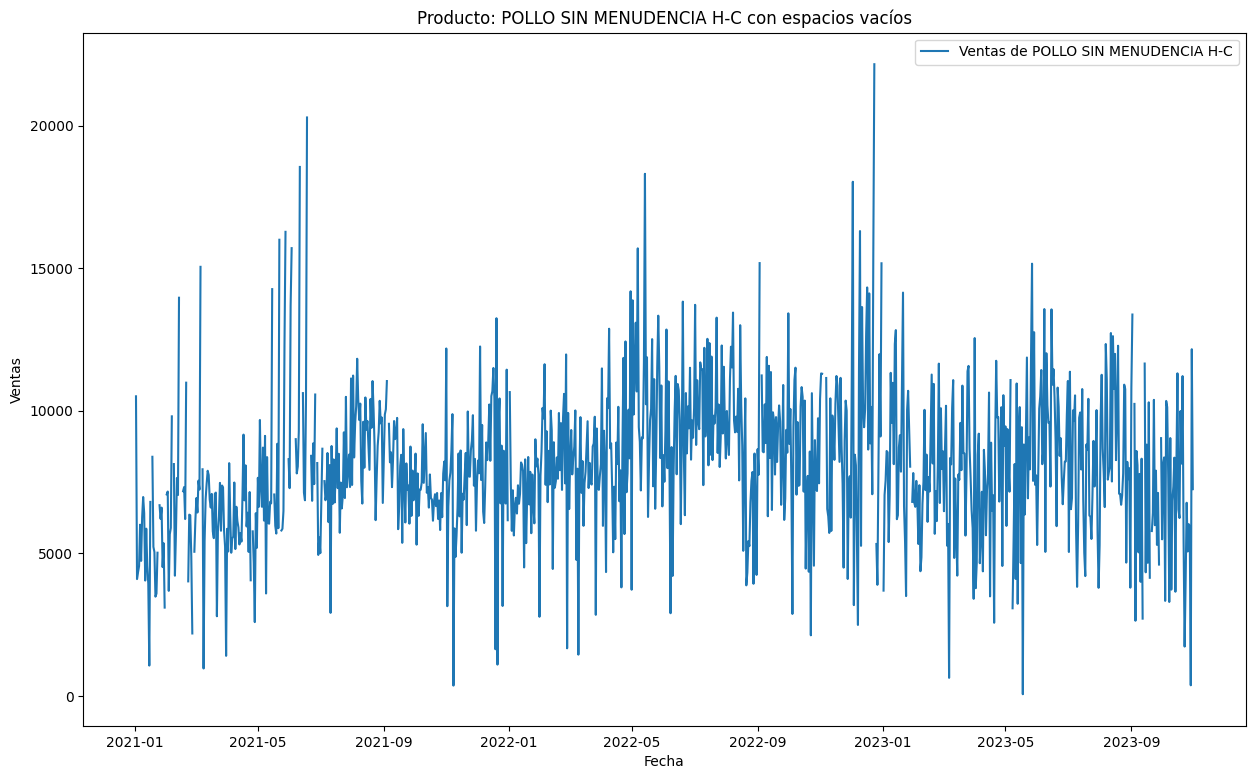

Número de fechas faltantes agregadas en POLLO SIN MENUDENCIA H-C:  37
     FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1         2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2         2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3         2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4         2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1029      2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1030      2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1031      2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1032      2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1033 rows x 3 columns]


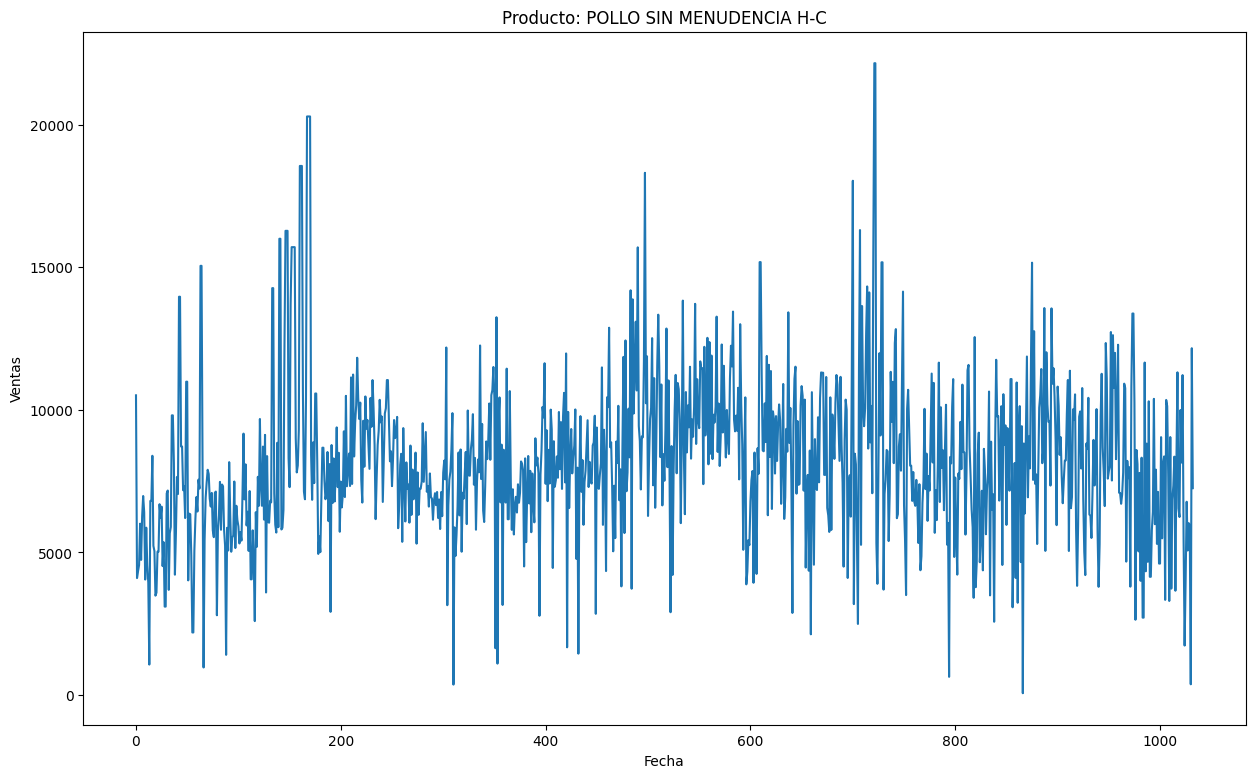

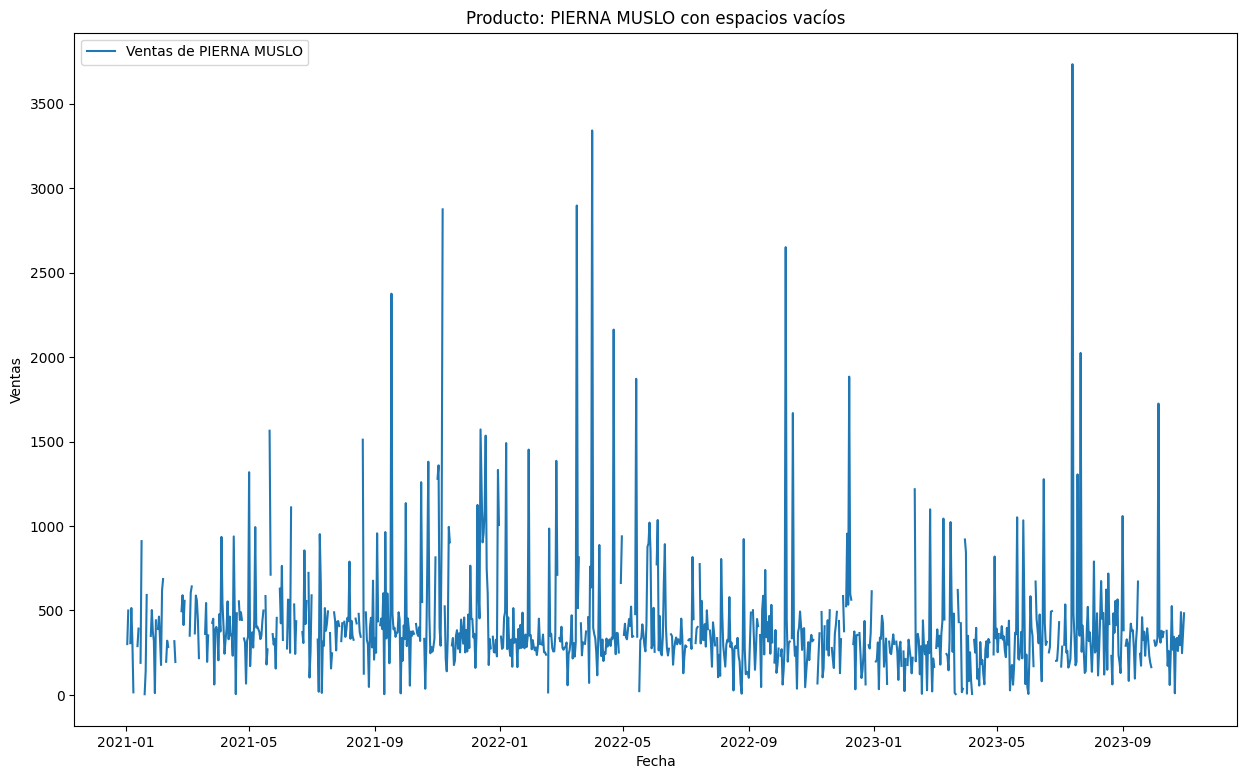

Número de fechas faltantes agregadas en PIERNA MUSLO:  129
     FechaMovimiento NombreProducto  MontoBase
0         2021-01-02   PIERNA MUSLO   301.0240
1         2021-01-03   PIERNA MUSLO   499.9280
2         2021-01-04   PIERNA MUSLO   499.9280
3         2021-01-05   PIERNA MUSLO   306.3600
4         2021-01-06   PIERNA MUSLO   514.6480
...              ...            ...        ...
1028      2023-10-27   PIERNA MUSLO   295.3844
1029      2023-10-28   PIERNA MUSLO   489.9276
1030      2023-10-29   PIERNA MUSLO   247.1948
1031      2023-10-30   PIERNA MUSLO   362.4432
1032      2023-10-31   PIERNA MUSLO   483.2576

[1033 rows x 3 columns]


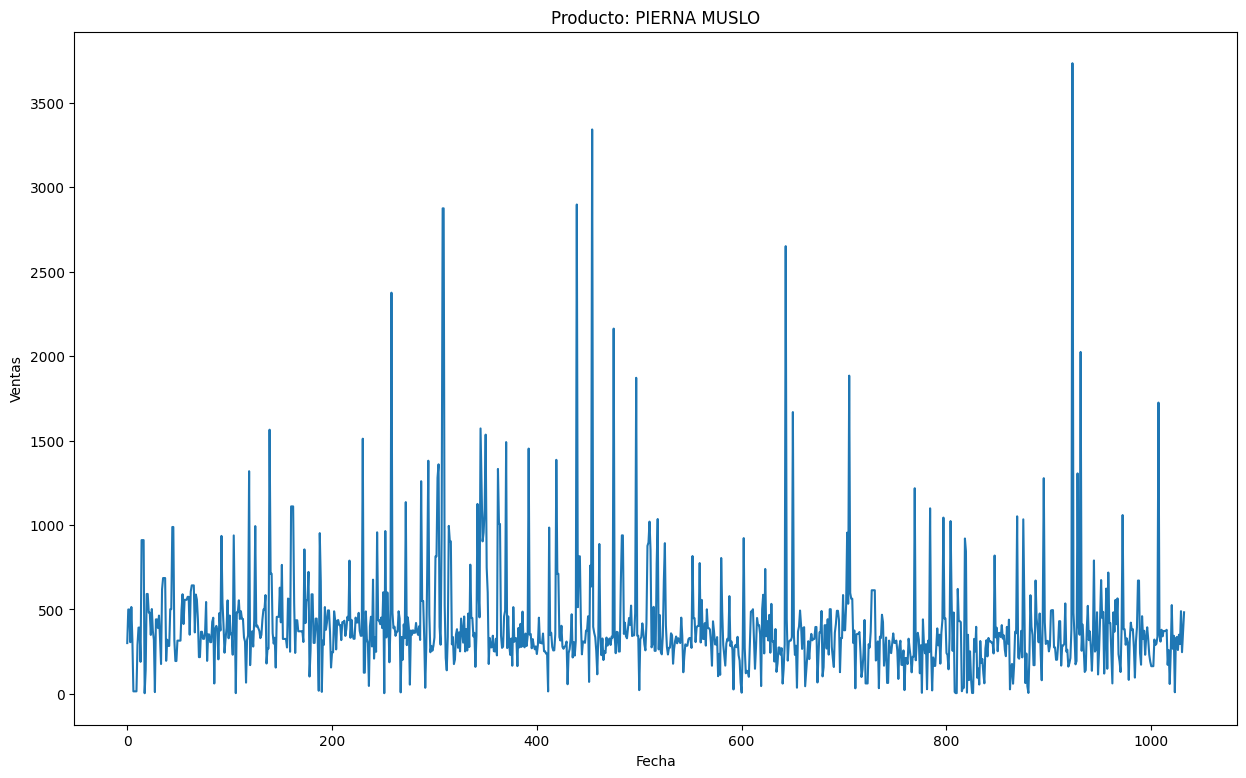

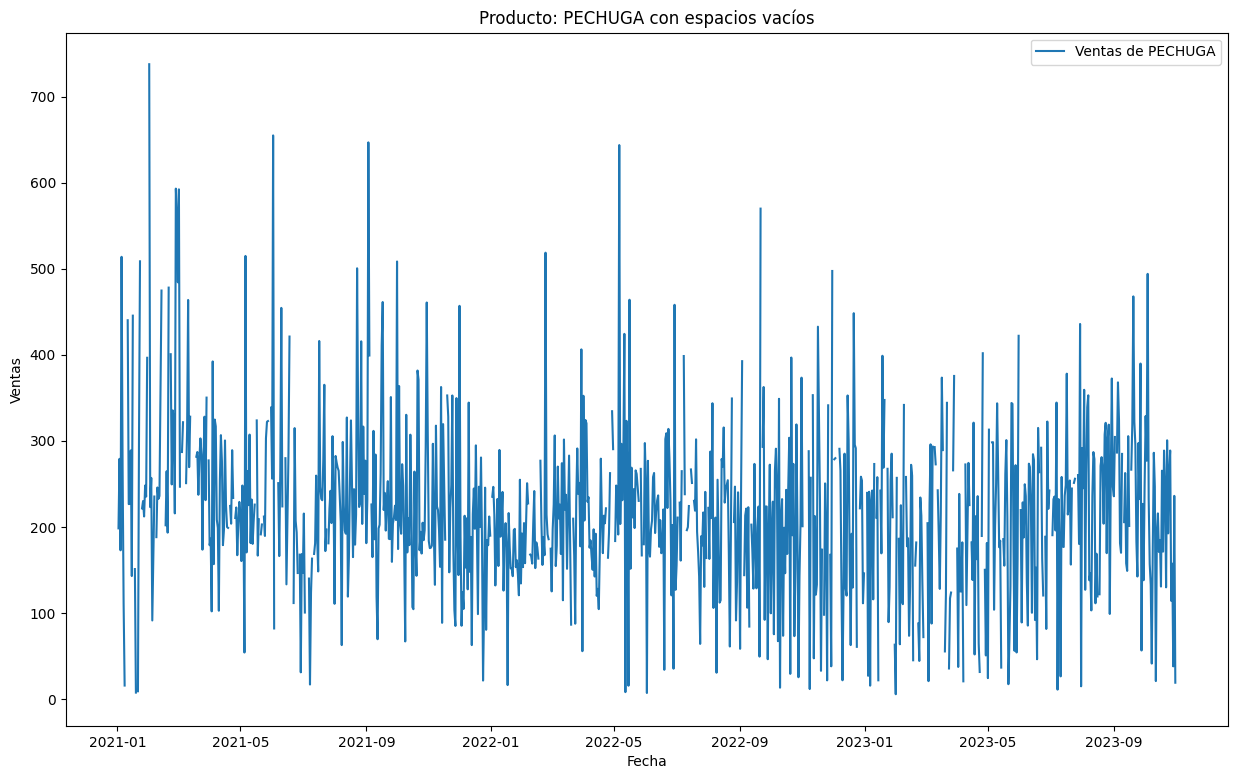

Número de fechas faltantes agregadas en PECHUGA:  109
     FechaMovimiento NombreProducto  MontoBase
0         2021-01-02        PECHUGA   198.3520
1         2021-01-03        PECHUGA   279.1280
2         2021-01-04        PECHUGA   172.8680
3         2021-01-05        PECHUGA   513.8200
4         2021-01-06        PECHUGA   270.5720
...              ...            ...        ...
1028      2023-10-27        PECHUGA   114.1536
1029      2023-10-28        PECHUGA   157.3936
1030      2023-10-29        PECHUGA    38.0512
1031      2023-10-30        PECHUGA   236.0904
1032      2023-10-31        PECHUGA    19.0256

[1033 rows x 3 columns]


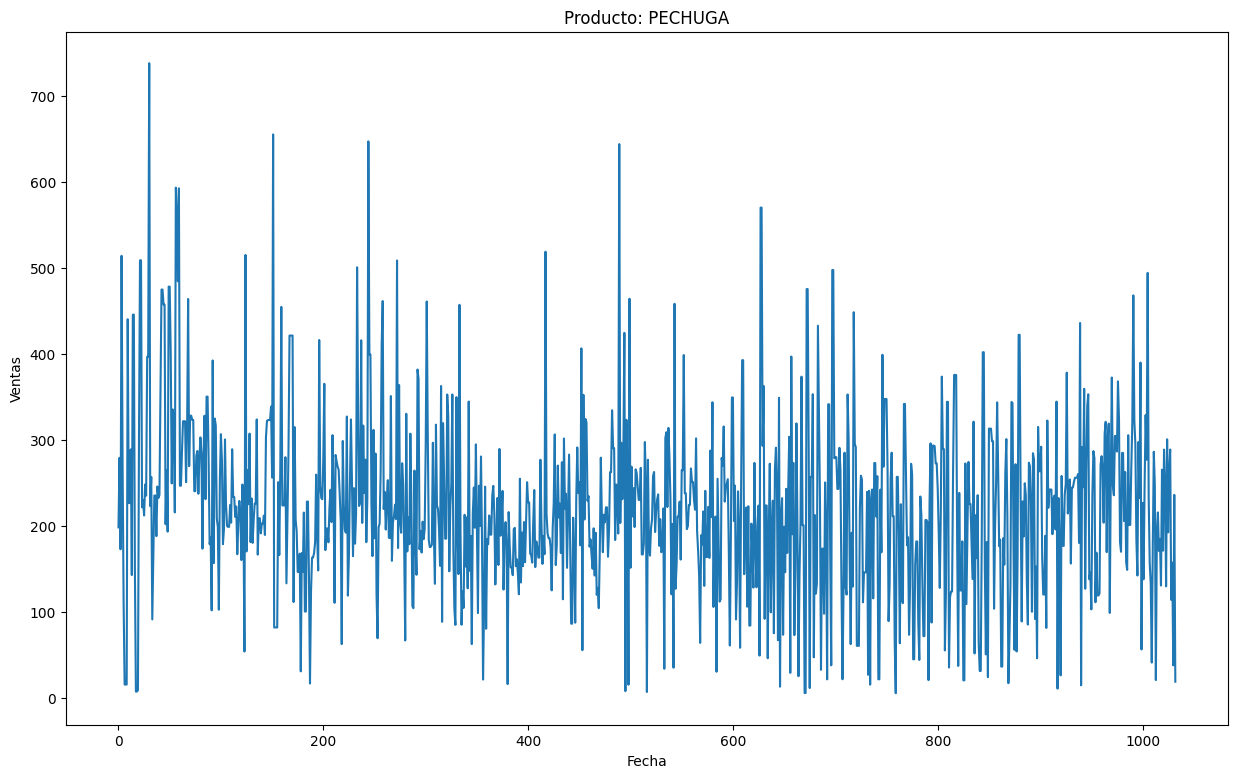

In [ ]:
# dfs_de_productos_sumados_ffill = {}
dfs_de_productos_sumados_ffill = deepcopy(dfs_de_productos_sumados)

# Iterar sobre los productos en el diccionario de productos sumados
for product, product_df_sumado_ffill in dfs_de_productos_sumados_ffill.items():

    # Reindexar para incluir todas las fechas desde el inicio hasta el final del rango deseado
    inicio = product_df_sumado_ffill.index.min()
    fin = product_df_sumado_ffill.index.max()
    fechas_completas = pd.date_range(start=inicio, end=fin)

    # Contar cuántas fechas faltantes se agregaron
    fechas_faltantes = fechas_completas.difference(product_df_sumado_ffill.index)
    contador_fechas_faltantes = len(fechas_faltantes)

    # Reindexar el DataFrame para incluir todas las fechas
    product_df_sumado_ffill = product_df_sumado_ffill.reindex(fechas_completas)

    # Graficar con espacios vacíos
    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label = f'Ventas de {product}')  # Plot para las ventas
    plt.title(f'Producto: {product} con espacios vacíos')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    # Rellenar los valores faltantes utilizando el método ffill() (forward fill)
    product_df_sumado_ffill['MontoBase'].fillna(method='ffill', inplace=True)
    product_df_sumado_ffill['NombreProducto'].fillna(method='ffill', inplace=True)

    print(f"Número de fechas faltantes agregadas en {product}: ", contador_fechas_faltantes)

    product_df_sumado_ffill.reset_index(inplace=True, drop=False)
    product_df_sumado_ffill.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

    print(product_df_sumado_ffill)

    plt.figure(figsize=(15, 9))
    plt.plot(product_df_sumado_ffill.index, product_df_sumado_ffill['MontoBase'], label=product_df_sumado_ffill['NombreProducto'])
    plt.title(f'Producto: {product}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.show()

    # # Resetear el índice y mantener el nombre de la columna de fecha
    # product_df_sumado_ffill.reset_index(inplace=True)
    # product_df_sumado_ffill.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

    dfs_de_productos_sumados_ffill[product] = product_df_sumado_ffill

In [ ]:
print(dfs_de_productos_sumados)

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  6008.0340
...                                   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 2 columns], 'PIERNA MUSLO':                 NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02        PIERNA MUSLO   301.0240
2021-01-03        PIERNA MUSLO   499.9280
2021-01-05        PIERNA MUSLO   306.3600
2021-01-06        PIERNA MUSLO 

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
# dfs_de_productos_sumados_prophet = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_prophet = deepcopy(dfs_de_productos_sumados_ffill)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    # product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    # product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

In [ ]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  6008.0340
...                                   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  7254.2832

[996 rows x 2 columns]>


In [ ]:
# print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
# print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)
print(list(dfs_de_productos_sumados_prophet.values())[1])

      index         ds NombreProducto        y
0         0 2021-01-02   PIERNA MUSLO 301.0240
1         1 2021-01-03   PIERNA MUSLO 499.9280
2         2 2021-01-04   PIERNA MUSLO 499.9280
3         3 2021-01-05   PIERNA MUSLO 306.3600
4         4 2021-01-06   PIERNA MUSLO 514.6480
...     ...        ...            ...      ...
1028   1028 2023-10-27   PIERNA MUSLO 295.3844
1029   1029 2023-10-28   PIERNA MUSLO 489.9276
1030   1030 2023-10-29   PIERNA MUSLO 247.1948
1031   1031 2023-10-30   PIERNA MUSLO 362.4432
1032   1032 2023-10-31   PIERNA MUSLO 483.2576

[1033 rows x 4 columns]


In [ ]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds            NombreProducto          y
0    2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1    2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2    2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3    2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4    2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
...         ...                       ...        ...
1028 2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1029 2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1030 2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1031 2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1032 2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1033 rows x 3 columns]
             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 301.0240
1    2021-01-03   PIERNA MUSLO 499.9280
2    2021-01-04   PIERNA MUSLO 499.9280
3    2021-01-05   PIERNA MUSLO 306.3600
4    2021-01-06   PIERNA MUSLO 514.6480
...         ...            ...      ...
1028 2023-10-27   PIERNA MUSLO 295.3844
1029 2023-10-28   P

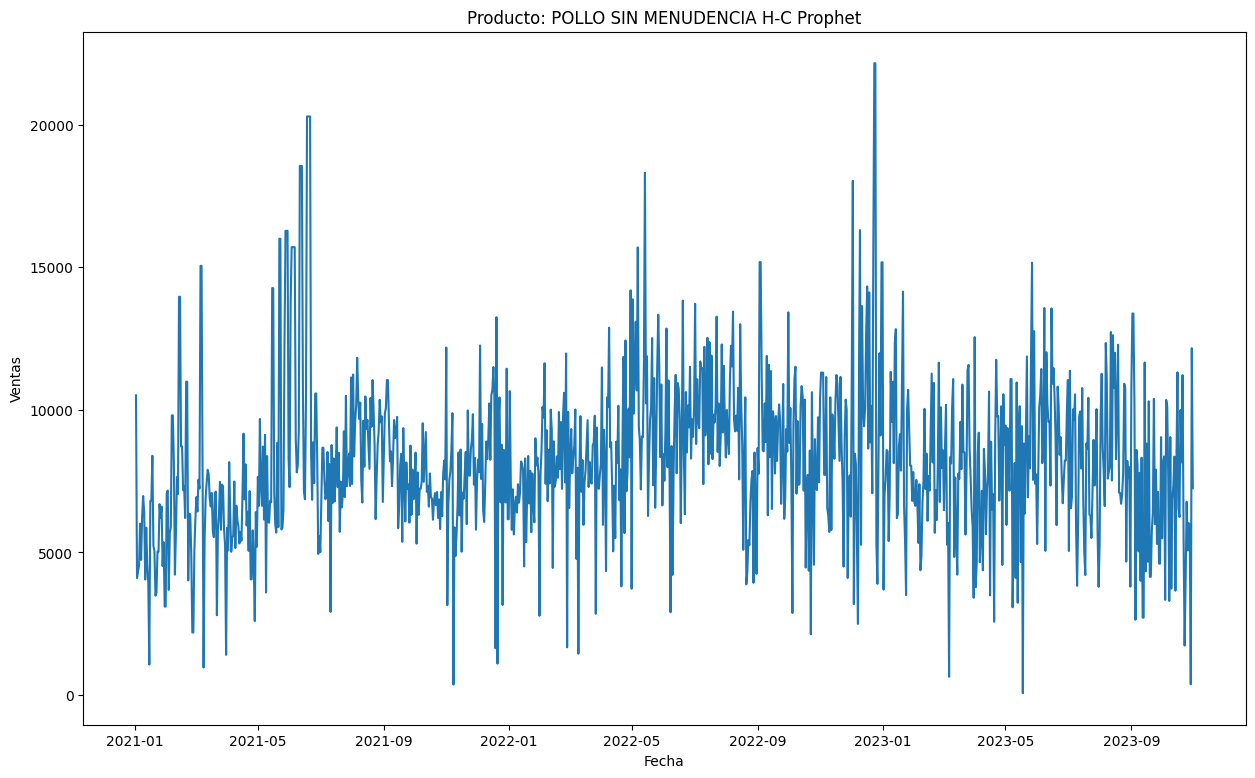

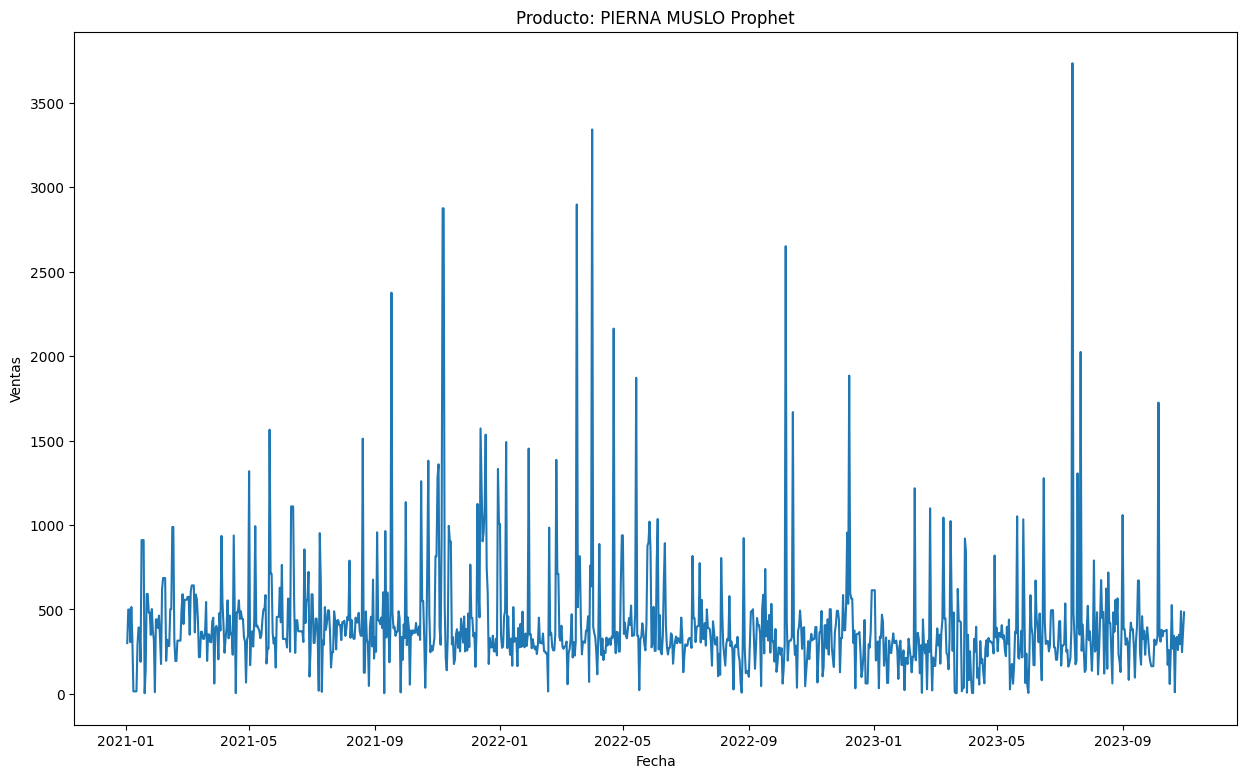

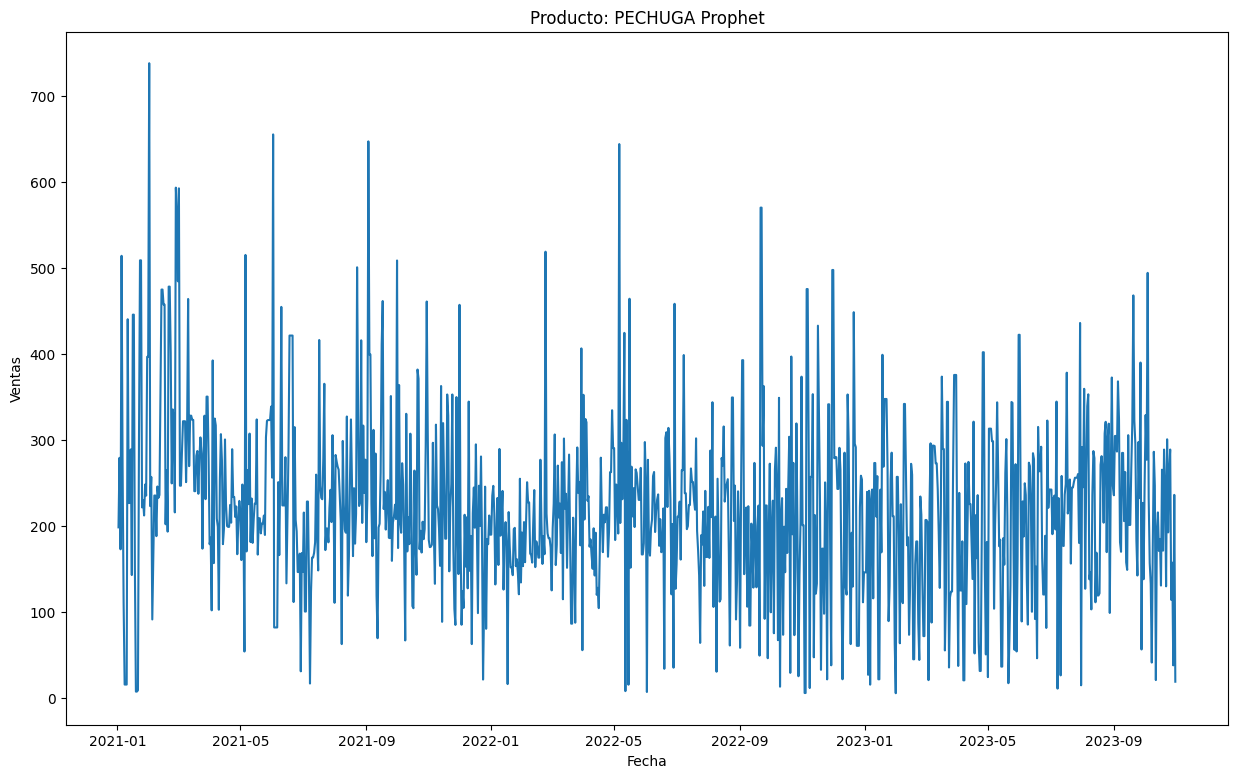

In [ ]:
# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Crear una nueva figura y ejes para cada producto
    fig, ax = plt.subplots(figsize=(15, 9))

    # Crear un gráfico de líneas para cada producto
    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product} Prophet')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas')
    plt.show()

In [ ]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [ ]:
dfs_de_productos_sumados_ffill

{'POLLO SIN MENUDENCIA H-C':      FechaMovimiento            NombreProducto  MontoBase
 0         2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
 1         2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
 2         2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
 3         2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
 4         2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
 ...              ...                       ...        ...
 1028      2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
 1029      2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
 1030      2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
 1031      2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
 1032      2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832
 
 [1033 rows x 3 columns],
 'PIERNA MUSLO':      FechaMovimiento NombreProducto  MontoBase
 0         2021-01-02   PIERNA MUSLO   301.0240
 1         2021-01-03   PIERNA MUSLO   499.9280
 2         2021-01-04   PIERNA MUSLO   499.9280
 3         2021-01-05   PIER

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
# dfs_de_productos_sumados_lstm = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_lstm = deepcopy(dfs_de_productos_sumados_ffill)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    # product_df_lstm.reset_index(inplace=True)
    print(product_df_lstm.head)
    print(product_df_lstm.dtypes)

    # Convertir 'FechaMovimiento' a tipo de dato datetime
    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    # Preprocesamiento de fechas utilizando el índice
    # product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    # product_df_lstm['Month'] = product_df_lstm.index.month
    # product_df_lstm['Year'] = product_df_lstm.index.year

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

    dfs_de_productos_sumados_lstm[product] = product_df_lstm

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase
0         2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1         2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2         2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3         2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4         2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
...              ...                       ...        ...
1028      2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1029      2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1030      2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1031      2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1032      2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1033 rows x 3 columns]>
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
NombreProducto     object
MontoBase         float64
dtype: object
<bound method NDFrame.head of      FechaMovimiento NombreProducto 

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
# dfs_de_productos_sumados_arima = deepcopy(dfs_de_productos_sumados)
dfs_de_productos_sumados_arima = deepcopy(dfs_de_productos_sumados_ffill)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():

    product_df_arima['FechaMovimiento'] = product_df_arima['FechaMovimiento'].dt.date

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)

In [ ]:
print(list(dfs_de_productos_sumados_arima.values())[2])
print(list(dfs_de_productos_sumados_arima.values())[2].dtypes)

                NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02             PECHUGA   198.3520
2021-01-03             PECHUGA   279.1280
2021-01-04             PECHUGA   172.8680
2021-01-05             PECHUGA   513.8200
2021-01-06             PECHUGA   270.5720
...                        ...        ...
2023-10-27             PECHUGA   114.1536
2023-10-28             PECHUGA   157.3936
2023-10-29             PECHUGA    38.0512
2023-10-30             PECHUGA   236.0904
2023-10-31             PECHUGA    19.0256

[1033 rows x 2 columns]
NombreProducto     object
MontoBase         float64
dtype: object


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [ ]:
# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_3_productos['NombreProducto']:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.3392
2023-11-17       POLLO SIN MENUDENCIA H-C  446

In [ ]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Se agregaron 0 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PIERNA MUSLO son: DatetimeIndex(['2023-11-20', '2023-11-25', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PIERNA MUSLO en las fechas faltantes.
Se agregaron 6 registros de venta 0 para el producto PIERNA MUSLO en noviembre.
Las fechas que no están en el producto PECHUGA son: DatetimeIndex(['2023-11-23', '2023-11-25', '2023-11-27', '2023-11-29'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PECHUGA en las fechas faltantes.
Se agregaron 4 registros de venta 0 para el producto PECHUGA en noviembre.
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBa

In [ ]:
# print(dfs_noviembre_sumados)

# PROPHET


## Predecir cada uno de los 3 principales productos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/ekr831w4.json


             ds            NombreProducto          y
0    2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000
1    2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080
2    2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650
3    2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320
4    2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340
...         ...                       ...        ...
1028 2023-10-27  POLLO SIN MENUDENCIA H-C  6026.4036
1029 2023-10-28  POLLO SIN MENUDENCIA H-C  5949.4542
1030 2023-10-29  POLLO SIN MENUDENCIA H-C   374.6544
1031 2023-10-30  POLLO SIN MENUDENCIA H-C 12163.1227
1032 2023-10-31  POLLO SIN MENUDENCIA H-C  7254.2832

[1033 rows x 3 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/9rq3_0ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34196', 'data', 'file=/tmp/tmpv7b2afi7/ekr831w4.json', 'init=/tmp/tmpv7b2afi7/9rq3_0ro.json', 'output', 'file=/tmp/tmpv7b2afi7/prophet_modelz6u0n9qr/prophet_model-20240319213618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


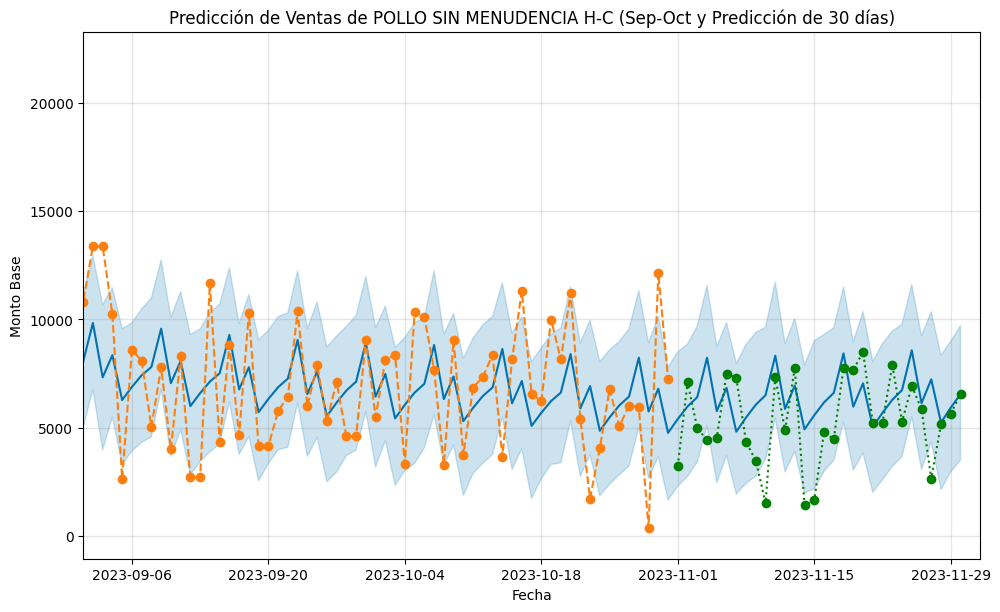

Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1033 2023-11-01 5404.8192
1034 2023-11-02 5982.6965
1035 2023-11-03 6412.9429
1036 2023-11-04 8231.5600
1037 2023-11-05 5767.1328
1038 2023-11-06 6840.1608
1039 2023-11-07 4817.6352
1040 2023-11-08 5472.7888
1041 2023-11-09 6063.0979
1042 2023-11-10 6503.2796
1043 2023-11-11 8329.3817
1044 2023-11-12 5870.1306
1045 2023-11-13 6946.2596
1046 2023-11-14 4925.0795
1047 2023-11-15 5580.2187
1048 2023-11-16 6169.6141
1049 2023-11-17 6608.4926
1050 2023-11-18 8433.4462
1051 2023-11-19 5973.7609
1052 2023-11-20 7050.7261
1053 2023-11-21 5032.1862
1054 2023-11-22 5692.2609
1055 2023-11-23 6289.3172
1056 2023-11-24 6738.9338
1057 2023-11-25 8577.9596
1058 2023-11-26 6135.8300
1059 2023-11-27 7233.8646
1060 2023-11-28 5239.8112
1061 2023-11-29 5927.5622
1062 2023-11-30 6555.1250


<Figure size 1600x1000 with 0 Axes>

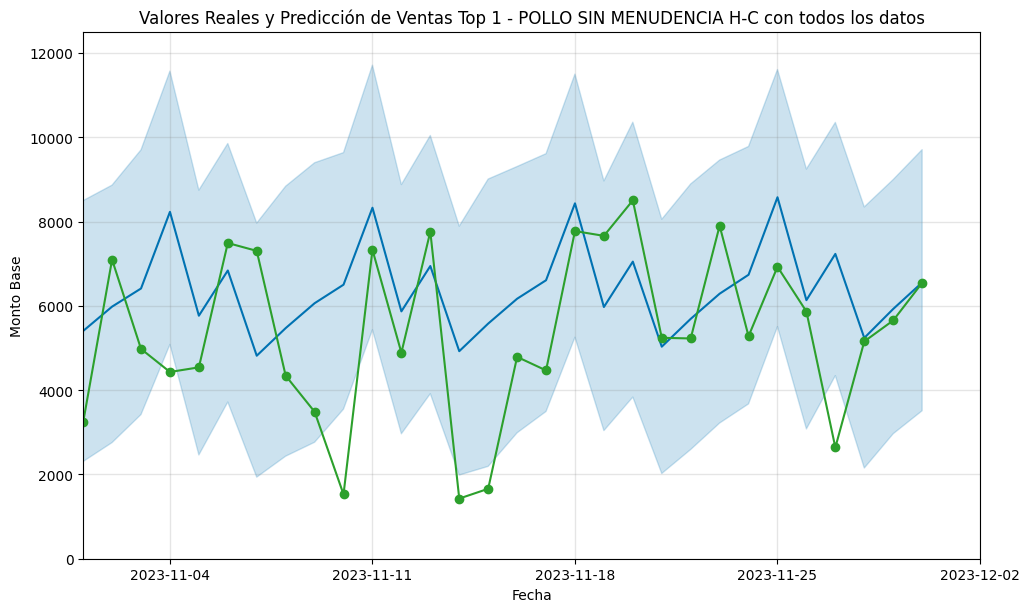

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/q5tj4xqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/ahrbh7wv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88080', 'data', 'file=/tmp/tmpv7b2afi7/q5tj4xqq.json', 'init=/tmp/tmpv7b2afi7/ahrbh7wv.json', 'output', 'file=/tmp/tmpv7b2afi7/prophet_modelmrh4x7in/prophet_model-20240319213619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 301.0240
1    2021-01-03   PIERNA MUSLO 499.9280
2    2021-01-04   PIERNA MUSLO 499.9280
3    2021-01-05   PIERNA MUSLO 306.3600
4    2021-01-06   PIERNA MUSLO 514.6480
...         ...            ...      ...
1028 2023-10-27   PIERNA MUSLO 295.3844
1029 2023-10-28   PIERNA MUSLO 489.9276
1030 2023-10-29   PIERNA MUSLO 247.1948
1031 2023-10-30   PIERNA MUSLO 362.4432
1032 2023-10-31   PIERNA MUSLO 483.2576

[1033 rows x 3 columns]


21:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


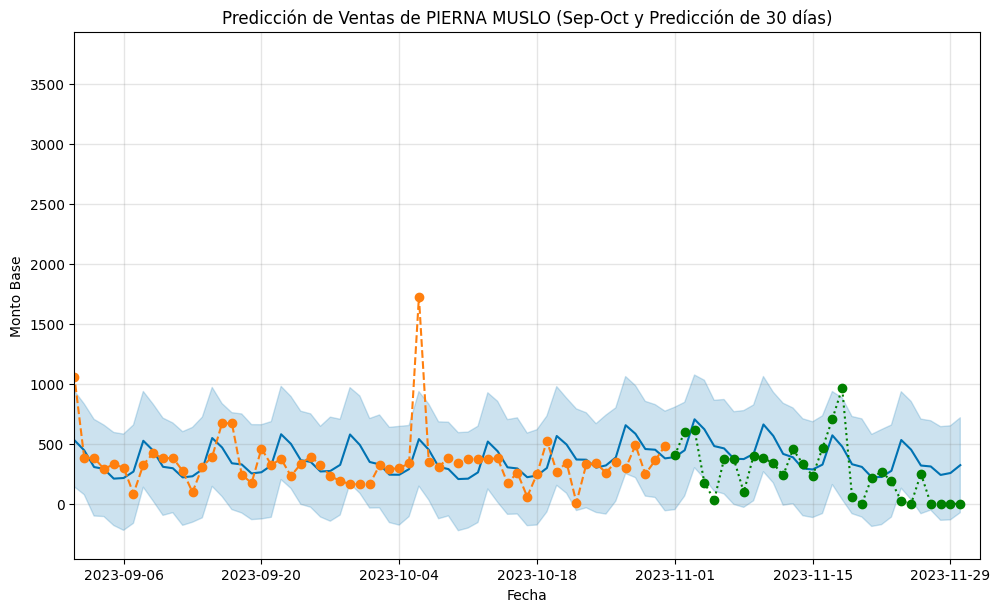

Predicción con todos los valores para PIERNA MUSLO:
             ds     yhat
1033 2023-11-01 389.8020
1034 2023-11-02 446.8334
1035 2023-11-03 704.6218
1036 2023-11-04 621.0745
1037 2023-11-05 481.2839
1038 2023-11-06 461.9909
1039 2023-11-07 375.8878
1040 2023-11-08 373.1411
1041 2023-11-09 416.6967
1042 2023-11-10 661.6849
1043 2023-11-11 566.3282
1044 2023-11-12 416.0133
1045 2023-11-13 387.7470
1046 2023-11-14 294.4513
1047 2023-11-15 286.4812
1048 2023-11-16 326.9239
1049 2023-11-17 571.0005
1050 2023-11-18 476.9709
1051 2023-11-19 330.2046
1052 2023-11-20 307.6366
1053 2023-11-21 222.0643
1054 2023-11-22 223.6682
1055 2023-11-23 275.3152
1056 2023-11-24 531.9652
1057 2023-11-25 451.5832
1058 2023-11-26 319.2169
1059 2023-11-27 311.4606
1060 2023-11-28 240.7605
1061 2023-11-29 256.9439
1062 2023-11-30 322.5316


<Figure size 1600x1000 with 0 Axes>

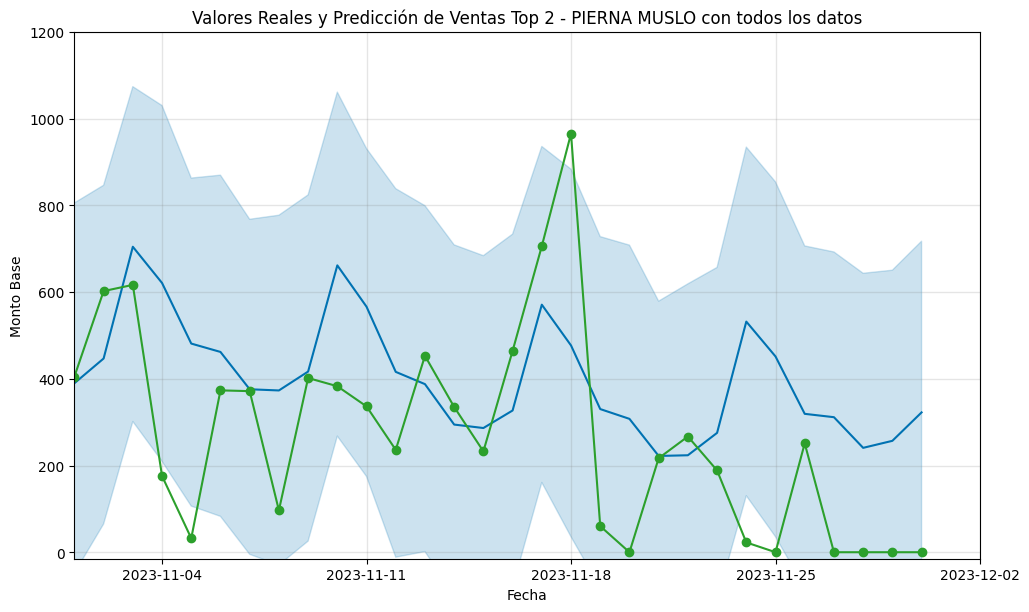

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/aku85w00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7b2afi7/84ej_dbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66799', 'data', 'file=/tmp/tmpv7b2afi7/aku85w00.json', 'init=/tmp/tmpv7b2afi7/84ej_dbb.json', 'output', 'file=/tmp/tmpv7b2afi7/prophet_modelq118t29l/prophet_model-20240319213621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


             ds NombreProducto        y
0    2021-01-02        PECHUGA 198.3520
1    2021-01-03        PECHUGA 279.1280
2    2021-01-04        PECHUGA 172.8680
3    2021-01-05        PECHUGA 513.8200
4    2021-01-06        PECHUGA 270.5720
...         ...            ...      ...
1028 2023-10-27        PECHUGA 114.1536
1029 2023-10-28        PECHUGA 157.3936
1030 2023-10-29        PECHUGA  38.0512
1031 2023-10-30        PECHUGA 236.0904
1032 2023-10-31        PECHUGA  19.0256

[1033 rows x 3 columns]


21:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


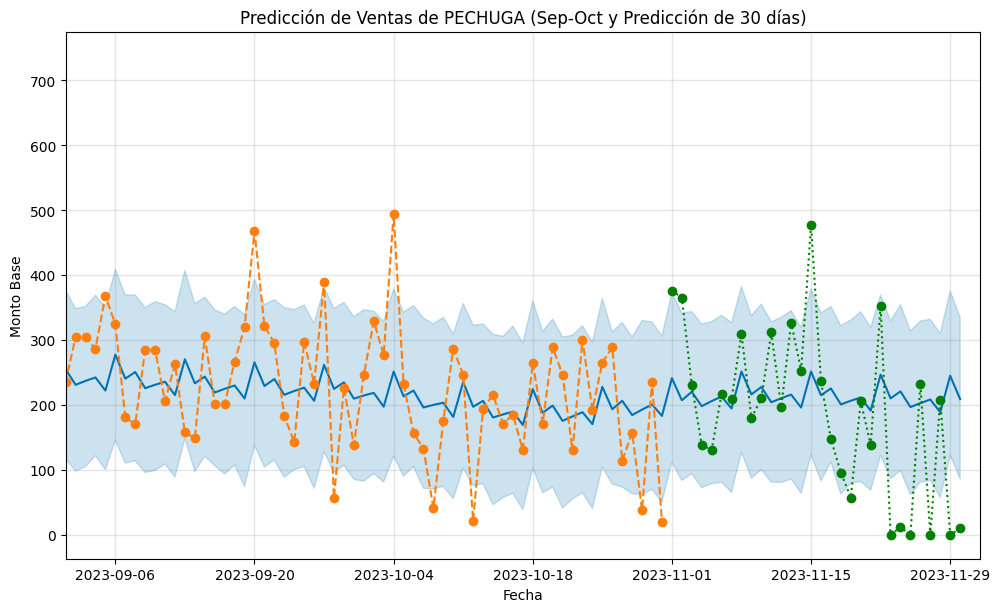

Predicción con todos los valores para PECHUGA:
             ds     yhat
1033 2023-11-01 241.2325
1034 2023-11-02 207.2052
1035 2023-11-03 220.1921
1036 2023-11-04 198.0855
1037 2023-11-05 205.9513
1038 2023-11-06 212.9813
1039 2023-11-07 194.5692
1040 2023-11-08 251.4943
1041 2023-11-09 216.1432
1042 2023-11-10 227.6895
1043 2023-11-11 204.0684
1044 2023-11-12 210.3898
1045 2023-11-13 215.8884
1046 2023-11-14 195.9997
1047 2023-11-15 251.5413
1048 2023-11-16 214.9338
1049 2023-11-17 225.3800
1050 2023-11-18 200.8383
1051 2023-11-19 206.4347
1052 2023-11-20 211.4135
1053 2023-11-21 191.2121
1054 2023-11-22 246.6429
1055 2023-11-23 210.1144
1056 2023-11-24 220.8105
1057 2023-11-25 196.6649
1058 2023-11-26 202.7740
1059 2023-11-27 208.3482
1060 2023-11-28 188.7882
1061 2023-11-29 244.8681
1062 2023-11-30 208.9576


<Figure size 1600x1000 with 0 Axes>

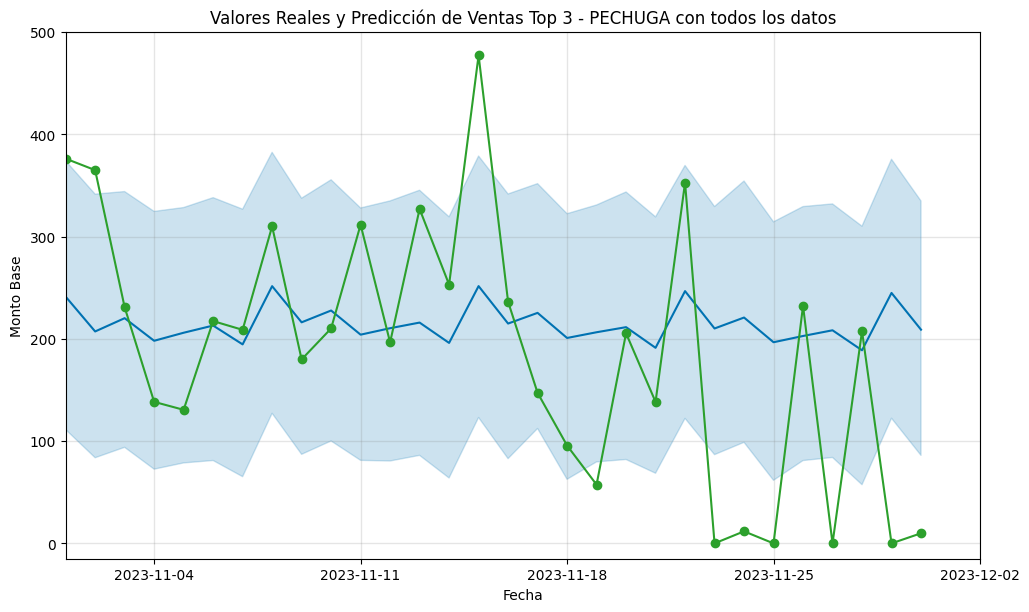

In [ ]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

contador = 0

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    contador += 1
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='tab:orange', marker='o', linestyle='dashed')
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label=f'Ventas reales noviembre - {product}', color='green', marker='o', linestyle='dotted')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    #Para el parametro del eje Y en el grafico del mes de noviembre
    if contador == 1:
        Minimo_Y = 0
        Maximo_Y = 12500
    elif contador == 2:
        Minimo_Y = -15
        Maximo_Y = 1200
    elif contador == 3:
        Minimo_Y = -15
        Maximo_Y = 500

    #Graficar solo Noviembre
    plt.figure(figsize=(16, 10))
    fig = modelo.plot(prediccion)
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]['MontoBase'], label='Ventas reales de noviembre', color='tab:green', marker='o')
    plt.title(f'Valores Reales y Predicción de Ventas Top {contador} - {product} con todos los datos')
    plt.xlabel('Fecha')
    plt.ylabel('Monto Base')
    plt.xlim([fecha_inicio_nov, fecha_fin])
    plt.ylim([Minimo_Y, Maximo_Y])
    plt.show()

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.

In [ ]:
dfs_noviembre_sumados

{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
 FechaMovimiento                                        
 2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
 2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
 2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
 2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
 2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
 2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
 2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
 2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
 2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
 2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
 2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
 2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
 2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
 2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
 2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
 20

# LSTM


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [ ]:
# print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(list(dfs_de_productos_sumados_lstm.values())[0])
print(dfs_de_productos_sumados_lstm)

                           NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  4341.8650
2021-01-05       POLLO SIN MENUDENCIA H-C  4555.7320
2021-01-06       POLLO SIN MENUDENCIA H-C  6008.0340
...                                   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  6026.4036
2023-10-28       POLLO SIN MENUDENCIA H-C  5949.4542
2023-10-29       POLLO SIN MENUDENCIA H-C   374.6544
2023-10-30       POLLO SIN MENUDENCIA H-C 12163.1227
2023-10-31       POLLO SIN MENUDENCIA H-C  7254.2832

[1033 rows x 2 columns]
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase
FechaMovimiento                                     
2021-01-02       POLLO SIN MENUDENCIA H-C 10510.9000
2021-01-03       POLLO SIN MENUDENCIA H-C  4100.4080
2021-01-04       POLLO SIN MENUDENCIA H-C  43

In [ ]:
# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Longitud del producto - POLLO SIN MENUDENCIA H-C : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                 

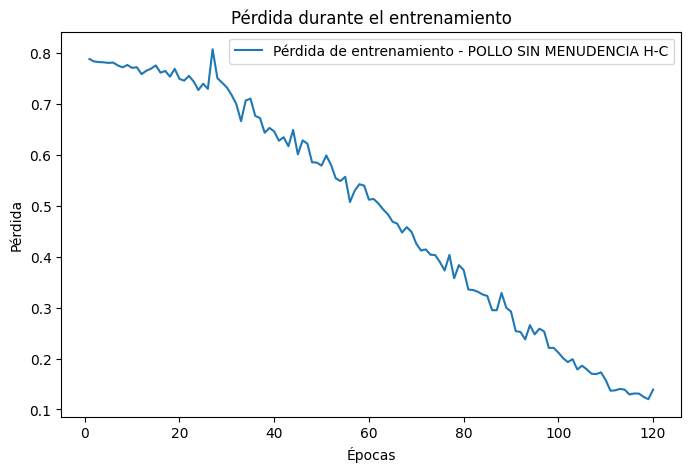

1/1 [==============================] - 1s 1s/step
31


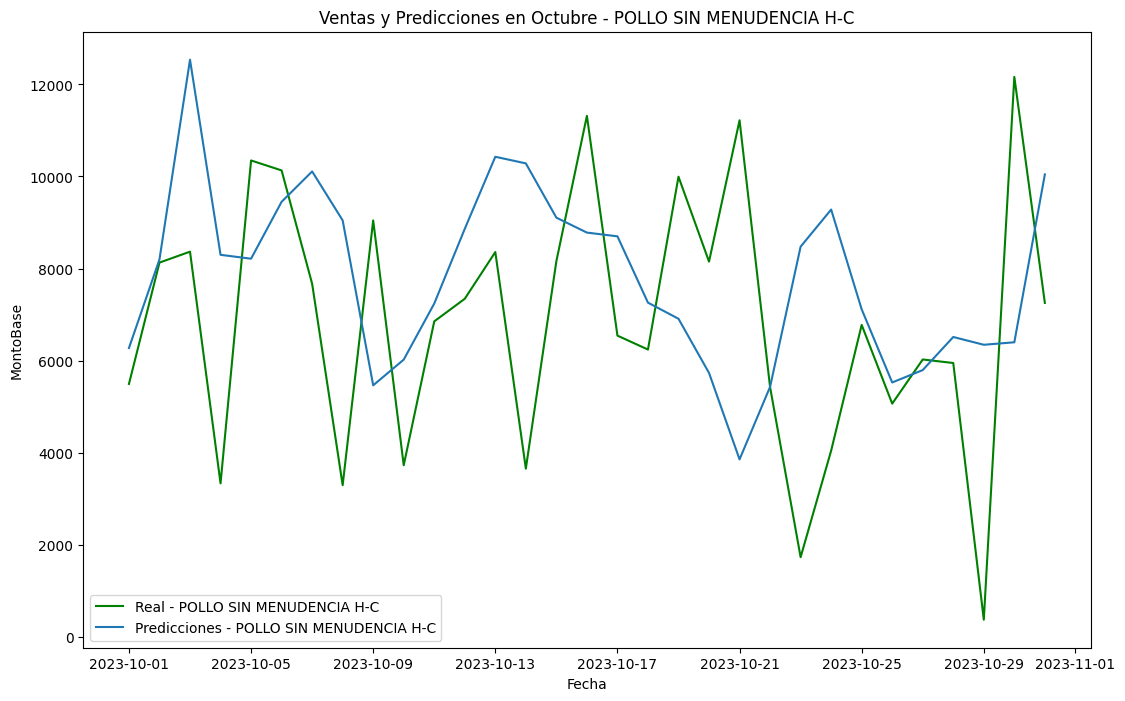

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 135ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                               8200.0918
2023-11-02                              12535.9902
2023-11-03                               8299.0059
2023-11-04                               8214.8789
2023-11-05                               9450.2412
2023-11-06                              10110.2002
2023-11-07                               9046.8867
2023-11-08                               5465.0537
2023-11-09                               6022.9087
2023-11-10                               7240.8774
2023-11-11                               8863.8789
2023-11-12                              10428.6172
2023-11-13                              10284.6719
2023-11-14   

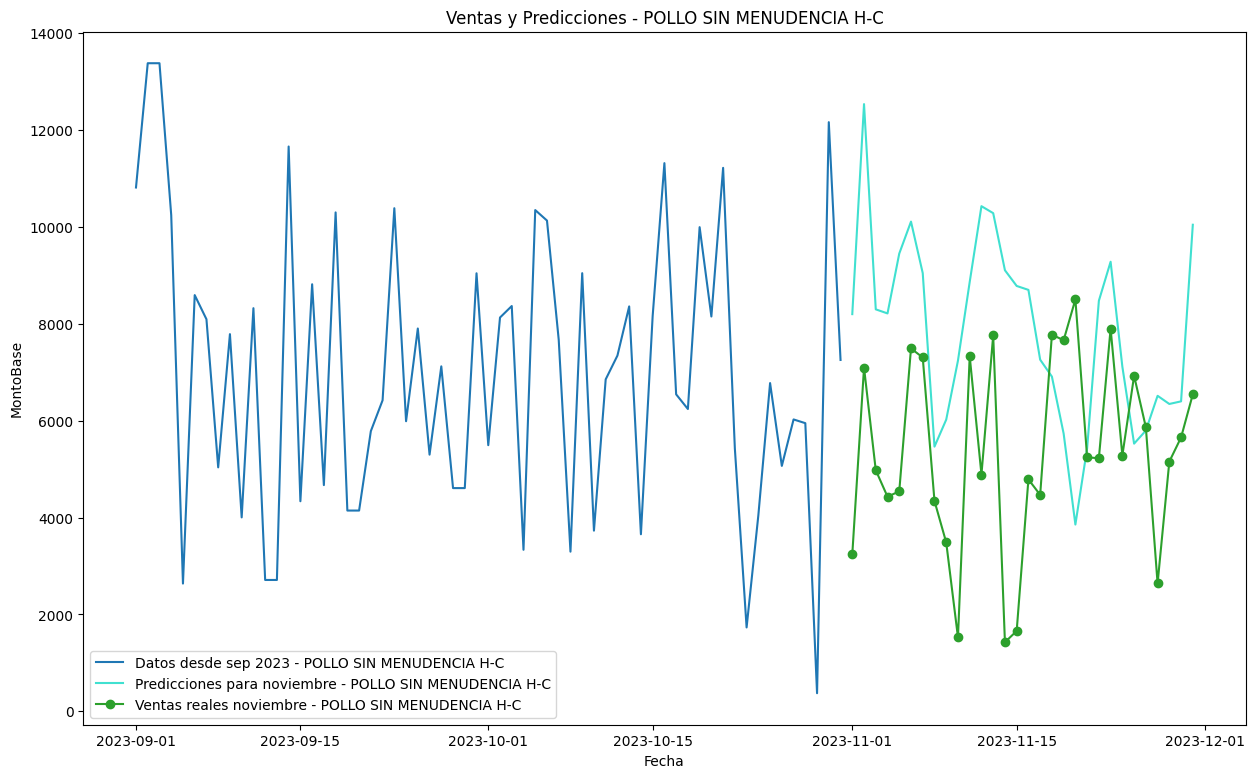

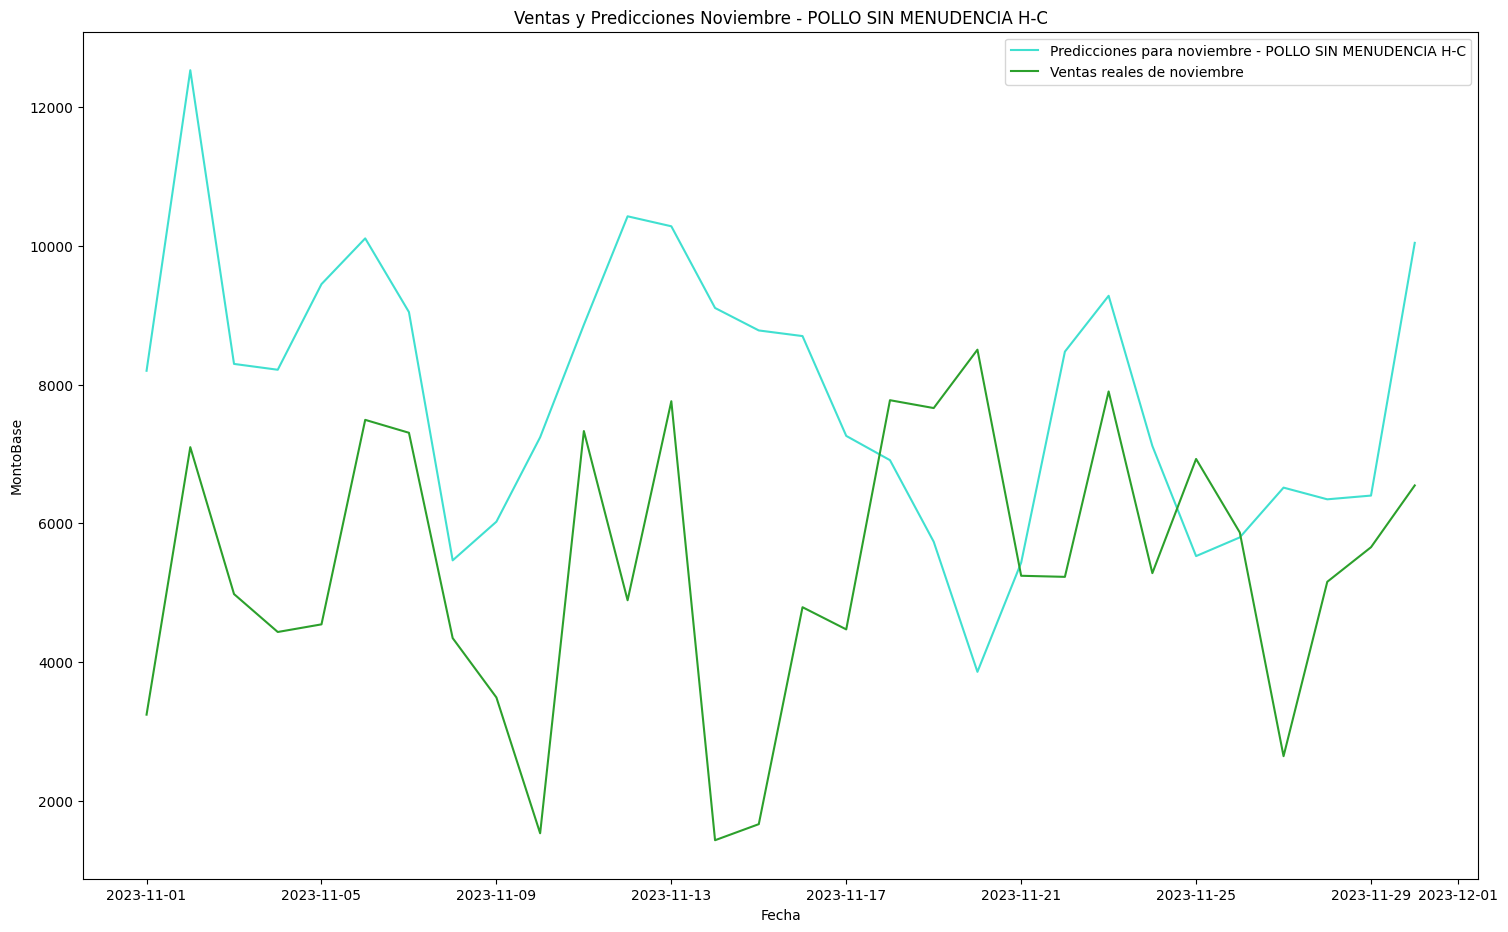

Longitud del producto - PIERNA MUSLO : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_2 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                           

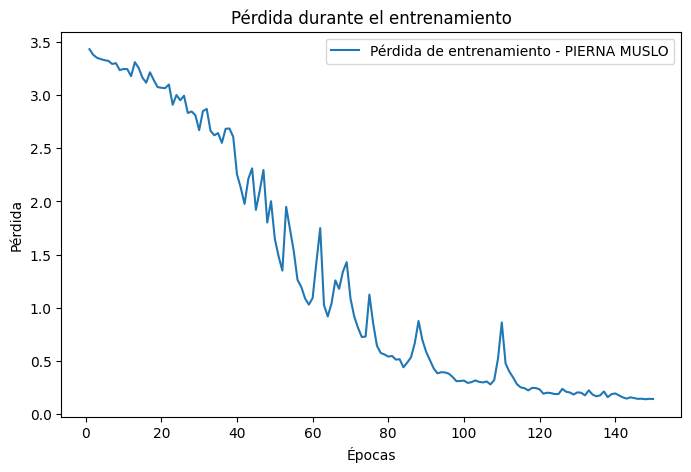

1/1 [==============================] - 1s 943ms/step
31


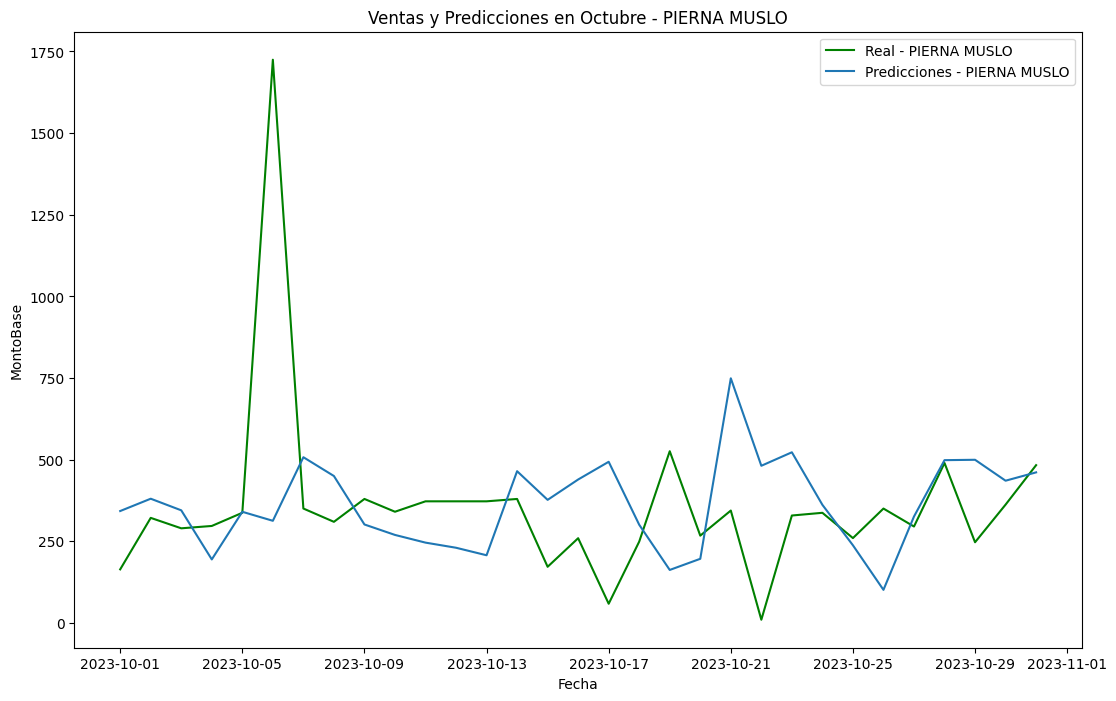

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 64ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_PIERNA MUSLO
FechaMovimiento                       
2023-11-01                    380.5249
2023-11-02                    344.9603
2023-11-03                    194.6368
2023-11-04                    340.4932
2023-11-05                    312.9044
2023-11-06                    507.5777
2023-11-07                    450.0493
2023-11-08                    301.6521
2023-11-09                    269.6526
2023-11-10                    246.0735
2023-11-11                    230.3881
2023-11-12                    207.3776
2023-11-13                    464.7840
2023-11-14                    377.0150
2023-11-15                    439.3458
2023-11-16                    493.5811
2023-11-17                    300.8097
2023-11-18                    162.4338

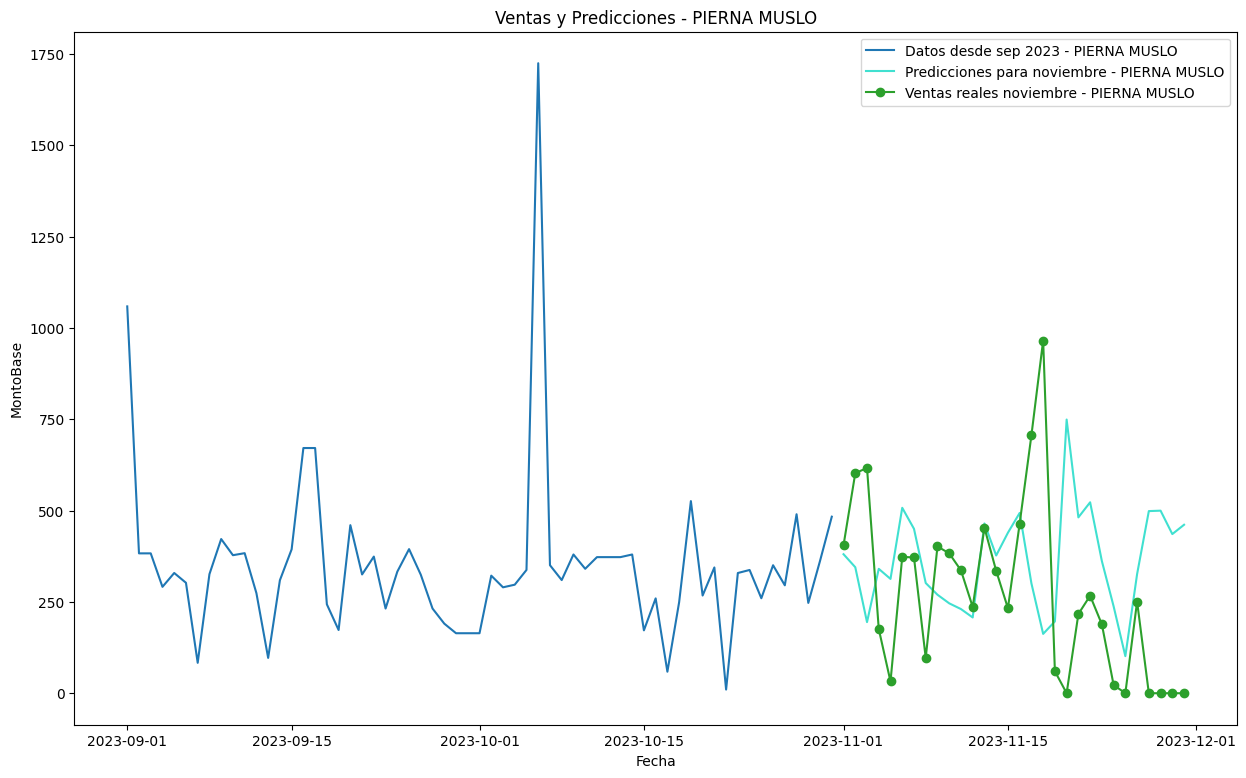

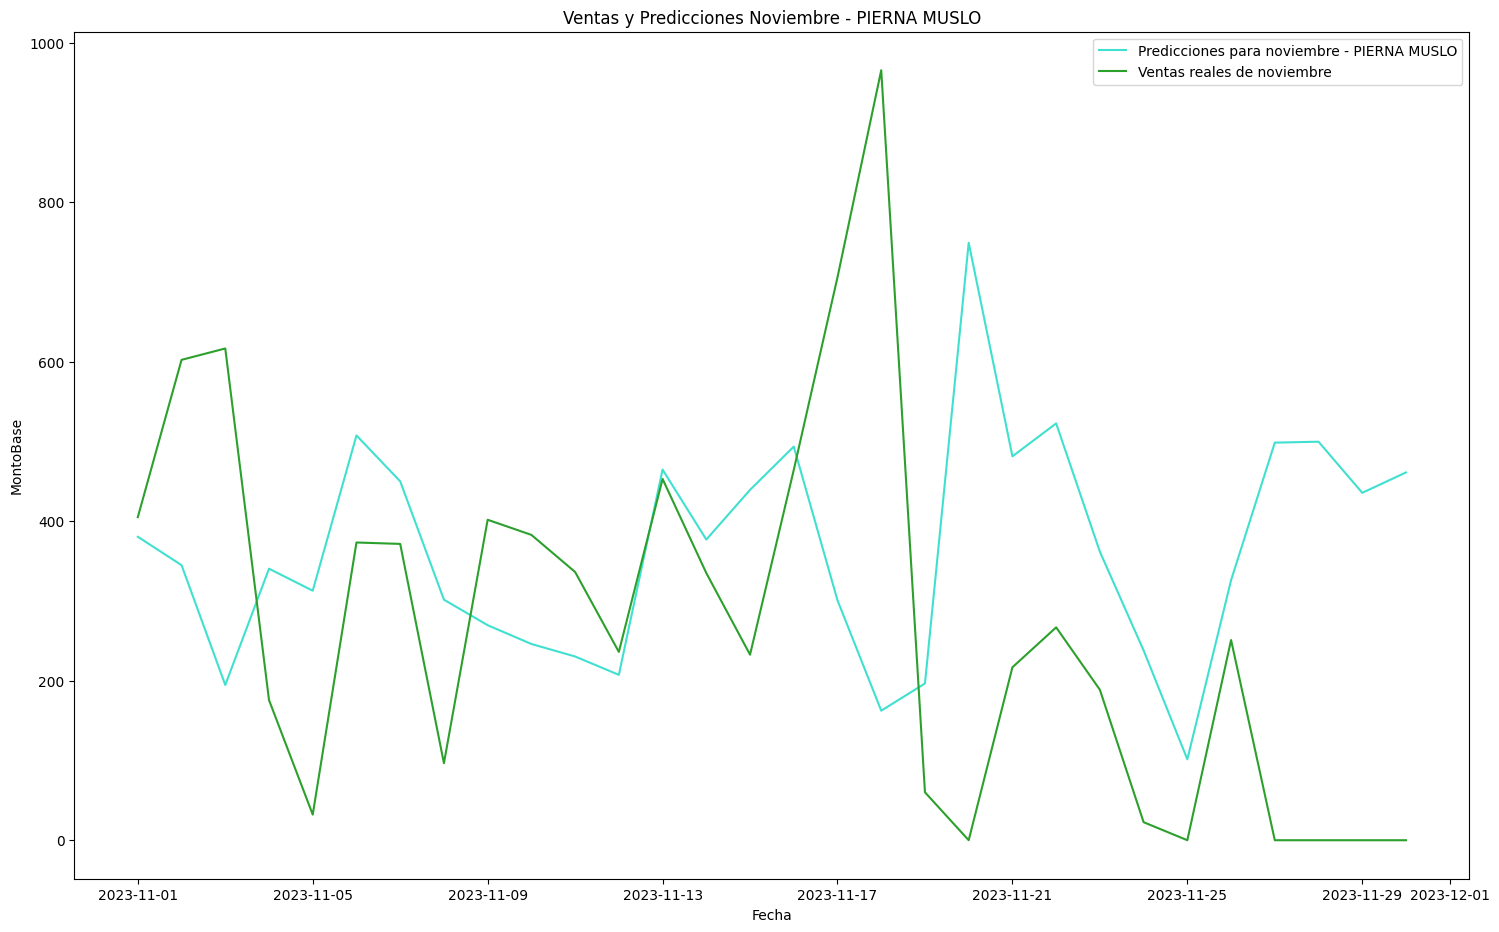

Longitud del producto - PECHUGA : (1033, 3)
Forma de X: (973, 30, 1)
Forma de y: (973,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_4 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                

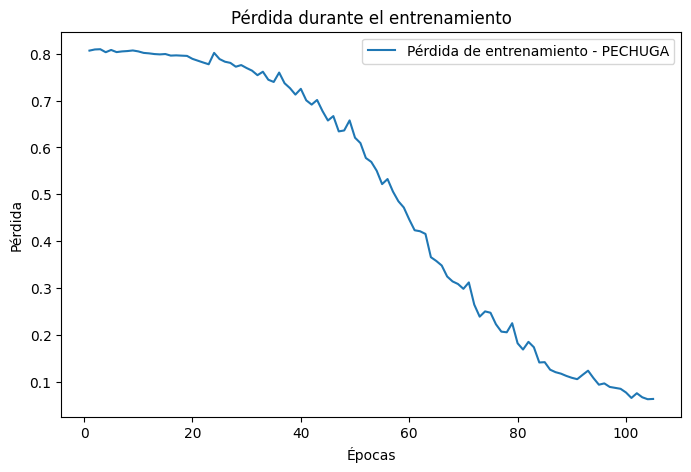

1/1 [==============================] - 1s 1s/step
31


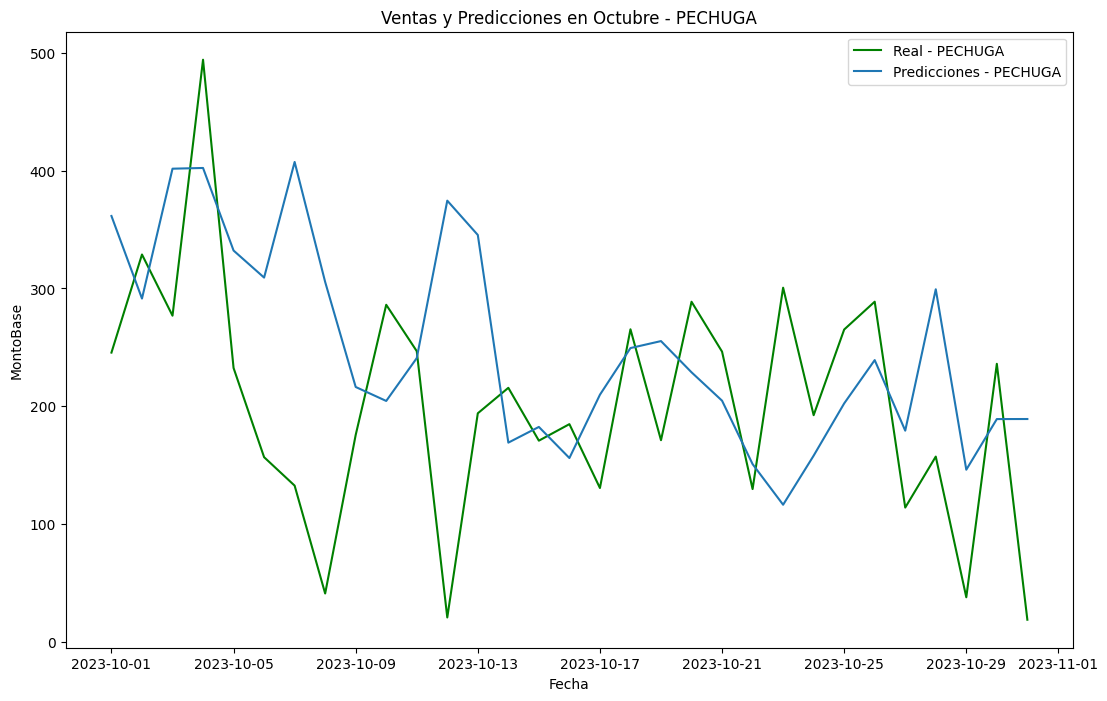

La longitud de las prediccioes es:  31
Dimensiones de predicciones: (31, 1)
La longitud de X_test es: 31 y la longitud de y_test es: 31
1/1 [==============================] - 0s 139ms/step
Forma de input_data: (30, 30, 1)
                 P-V_LSTM_PECHUGA
FechaMovimiento                  
2023-11-01               291.4293
2023-11-02               401.5868
2023-11-03               402.1994
2023-11-04               332.1551
2023-11-05               309.2226
2023-11-06               407.2955
2023-11-07               305.5155
2023-11-08               216.4339
2023-11-09               204.5836
2023-11-10               240.9205
2023-11-11               374.4751
2023-11-12               345.3590
2023-11-13               169.2331
2023-11-14               182.5495
2023-11-15               156.1764
2023-11-16               209.8686
2023-11-17               249.4512
2023-11-18               255.3610
2023-11-19               228.8878
2023-11-20               204.8072
2023-11-21               151.0

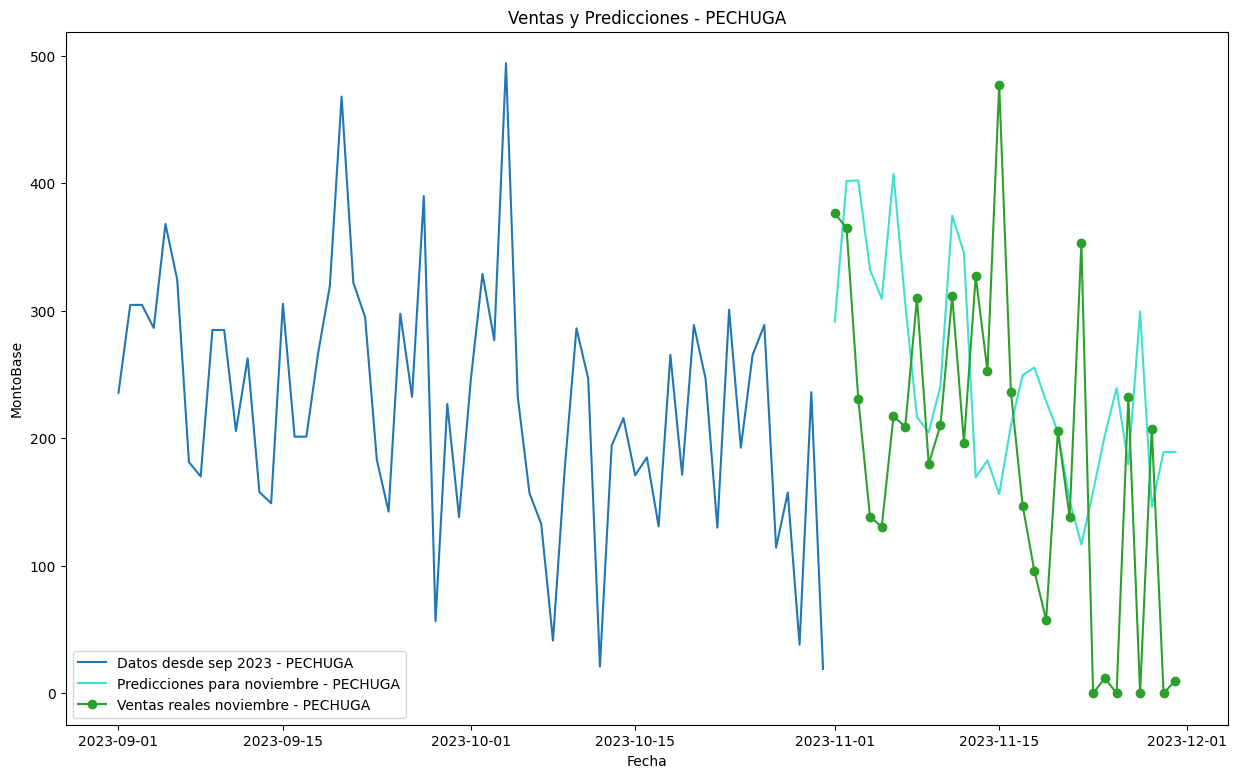

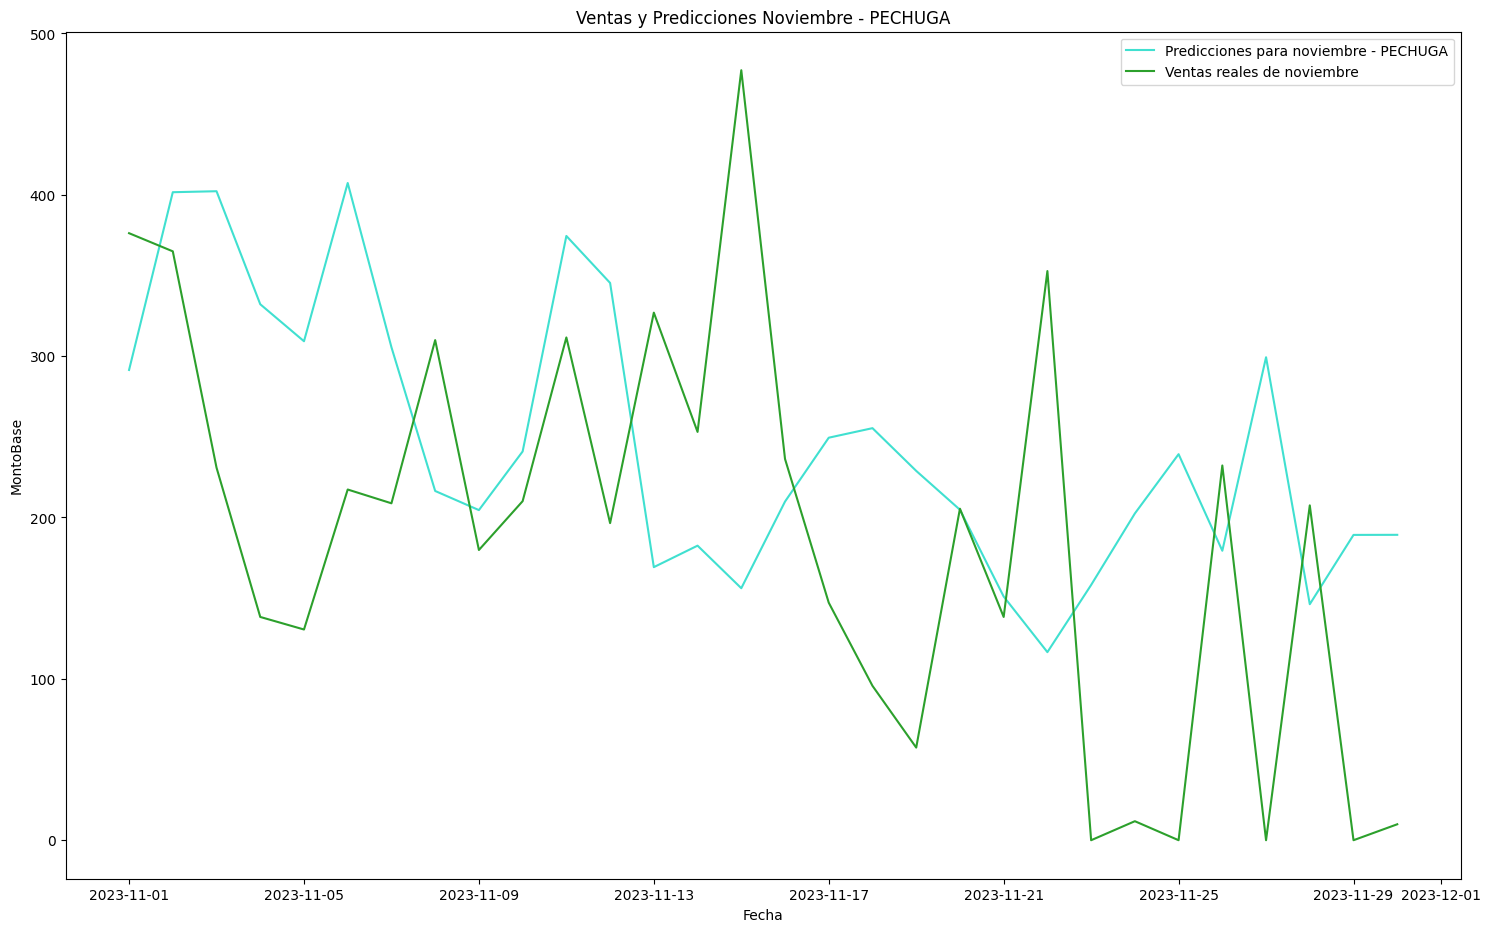

In [ ]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

contador = 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    contador += 1
    # Normalizar los datos
    scaler = RobustScaler()
    product_df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    time_steps = 30
    X, y = create_sequences_dwp(product_df_lstm['MontoBase_robust_scaler'].values, seq_length, time_steps)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) - 31)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    print(f"Longitud del producto - {product} :", product_df_lstm.shape)
    print("Forma de X:", X.shape)
    print("Forma de y:", y.shape)

    if contador == 1:
        lstm_epochs = 120
    elif contador == 2:
        lstm_epochs = 150
    elif contador == 3:
        lstm_epochs = 105

    # Construir el modelo LSTM
    model = Sequential()
    # 1º capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.2))

    # # 2º capa LSTM y Dropout para regularización.
    # model.add(LSTM(units = 100, return_sequences = True))
    # model.add(Dropout(rate=0.1))

    # 3ºa capa LSTM y Dropout para regularización.
    model.add(LSTM(units = 200, return_sequences = False))
    model.add(Dropout(rate=0.2))

    # Capa de Salida!
    model.add(Dense(units = 100, activation='relu'))
    model.add(Dense(units = 1))
    # Resumen del modelo!
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=30, verbose=1)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    longitud_predicciones = len(predictions)
    print(longitud_predicciones)
    # fechas_predicciones = pd.date_range(start='2023-11-01', periods=len(predictions))
    # print(fechas_predicciones)
    # Visualizar las predicciones
    plt.figure(figsize=(13, 8))
    plt.plot(product_df_lstm['MontoBase'].tail(len(X_test)), label='Real - ' + product, color = 'green')
    plt.plot(product_df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones - ' + product)
    # plt.plot(product_df_lstm['MontoBase'], label='Real - ' + product)
    # plt.plot(product_df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones en Octubre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(90)  # Últimos 90 días

    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))
    print("La longitud de las prediccioes es: ", longitud_predicciones)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')
    input_data, _ = create_sequences_dwp(input_data, seq_length, time_steps)
    input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

    # Hacer predicciones para los siguientes 30 días
    predictions_future = model.predict(input_data)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 9))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # plt.style.use('seaborn')
    # sns.set_palette("Dark2")
    plt.figure(figsize=(18, 11))
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    # plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(dates_future, predictions_future, label='Predicciones para noviembre - ' + product, color = 'turquoise')
    plt.plot(real_november_data.index, real_november_data['MontoBase'], label='Ventas reales de noviembre', color = 'tab:green')
    plt.title('Ventas y Predicciones Noviembre - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [ ]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO SIN MENUDENCIA H-C':                            NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA

## Evaluar LSTM




In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 13303934.929416018
MAE is : 3070.4397097786455
R2 is : -2.438972372798549 %
------------------------------
MRSE is : 3647.455953046728
MAPE is : 92.18648401903776 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 100947.2088140152
MAE is : 244.49926099731445
R2 is : -0.7771737391632374 %
------------------------------
MRSE is : 317.72190483820157
MAPE is : 134.85970235194634 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 24226.90488710796
MAE is : 131.37353358154297
R2 is : -0.5157344948781313 %
------------------------------
MRSE is 

# ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 2021-01-02 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1033 non-null   object 
 1   MontoBase       1033 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.2+ KB


Predicciones para POLLO SIN MENUDENCIA H-C:


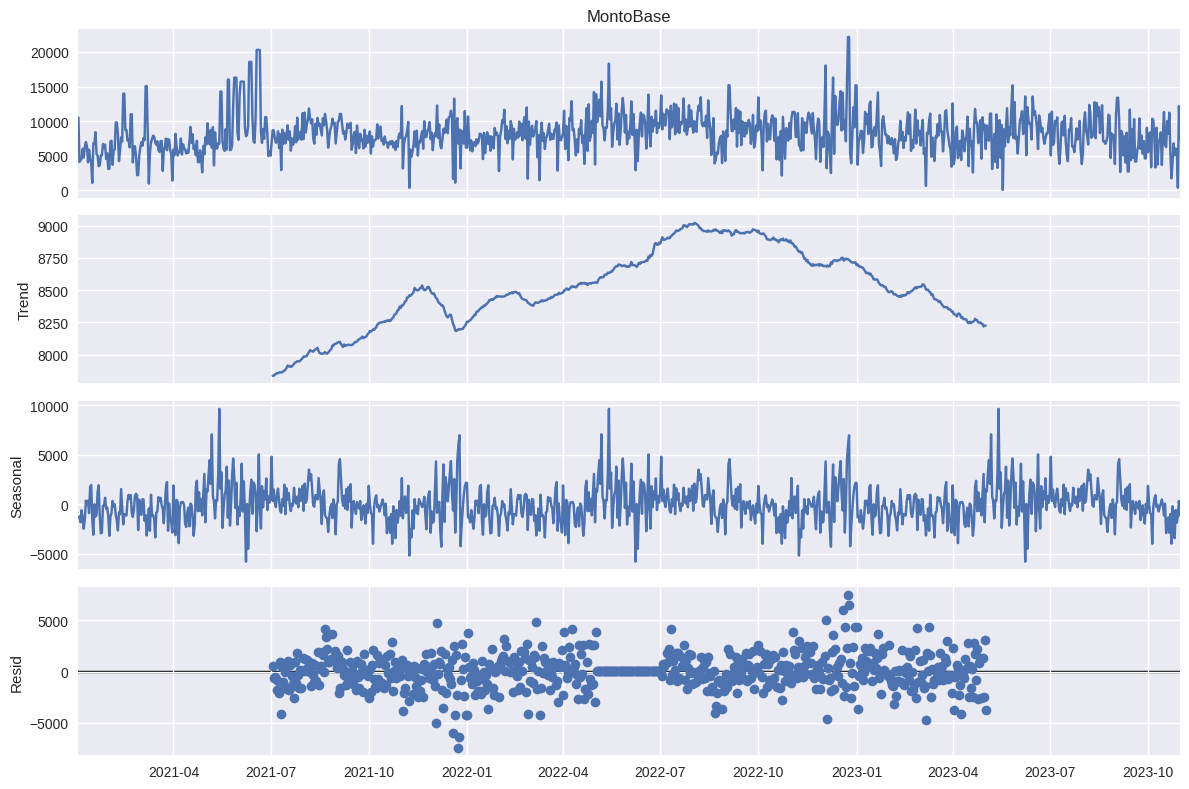

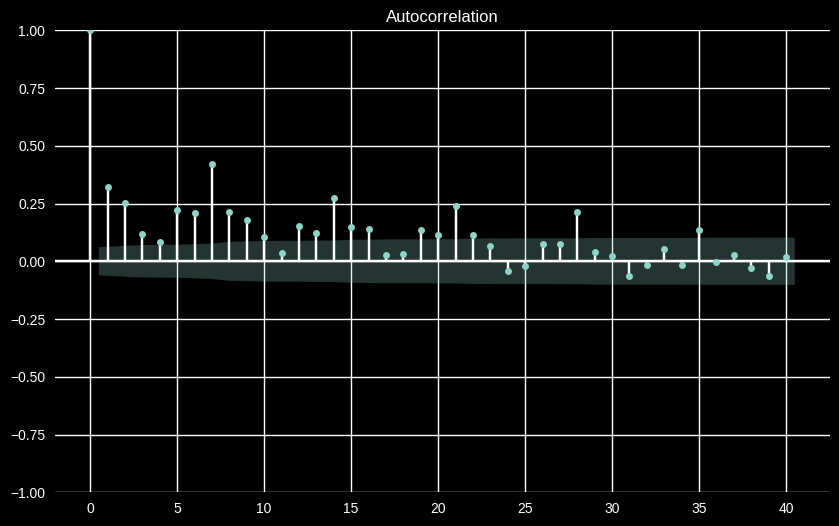

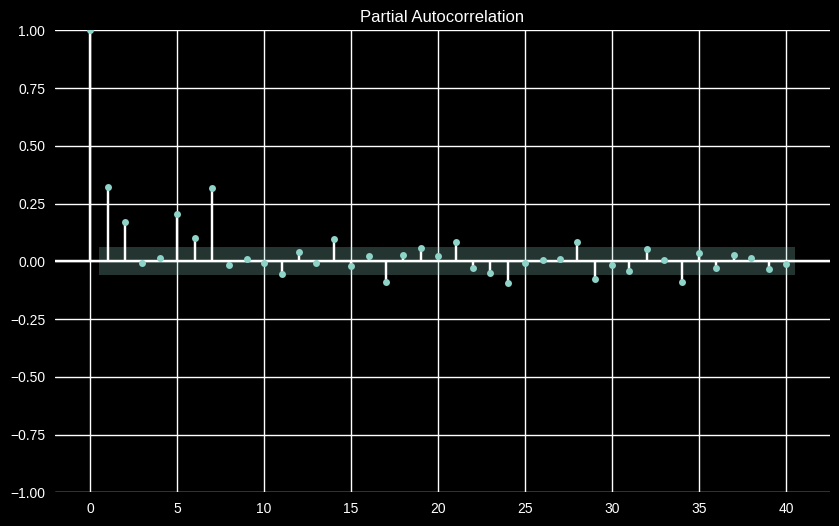

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-217-336059ccefa9>:96: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01   7290.9580
2023-10-02   4480.6993
2023-10-03   6715.2842
2023-10-04   5468.9357
2023-10-05   7677.9057
2023-10-06   5022.7950
2023-10-07   6300.9860
2023-10-08   7372.0103
2023-10-09   6929.6569
2023-10-10   5850.2954
2023-10-11   3277.0687
2023-10-12   7955.4019
2023-10-13   6476.3819
2023-10-14   3045.0144
2023-10-15   5714.0219
2023-10-16   4109.4197
2023-10-17   6669.4772
2023-10-18   2500.9254
2023-10-19   5028.2440
2023-10-20   8419.1040
2023-10-21   6309.3684
2023-10-22   6164.7939
2023-10-23   2068.3387
2023-10-24   7348.1909
2023-10-25   4700.1800
2023-10-26   2474.0265
2023-10-27   4803.7405
2023-10-28   3324.0659
2023-10-29   6739.2799
2023-10-30   2295.0866
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO S

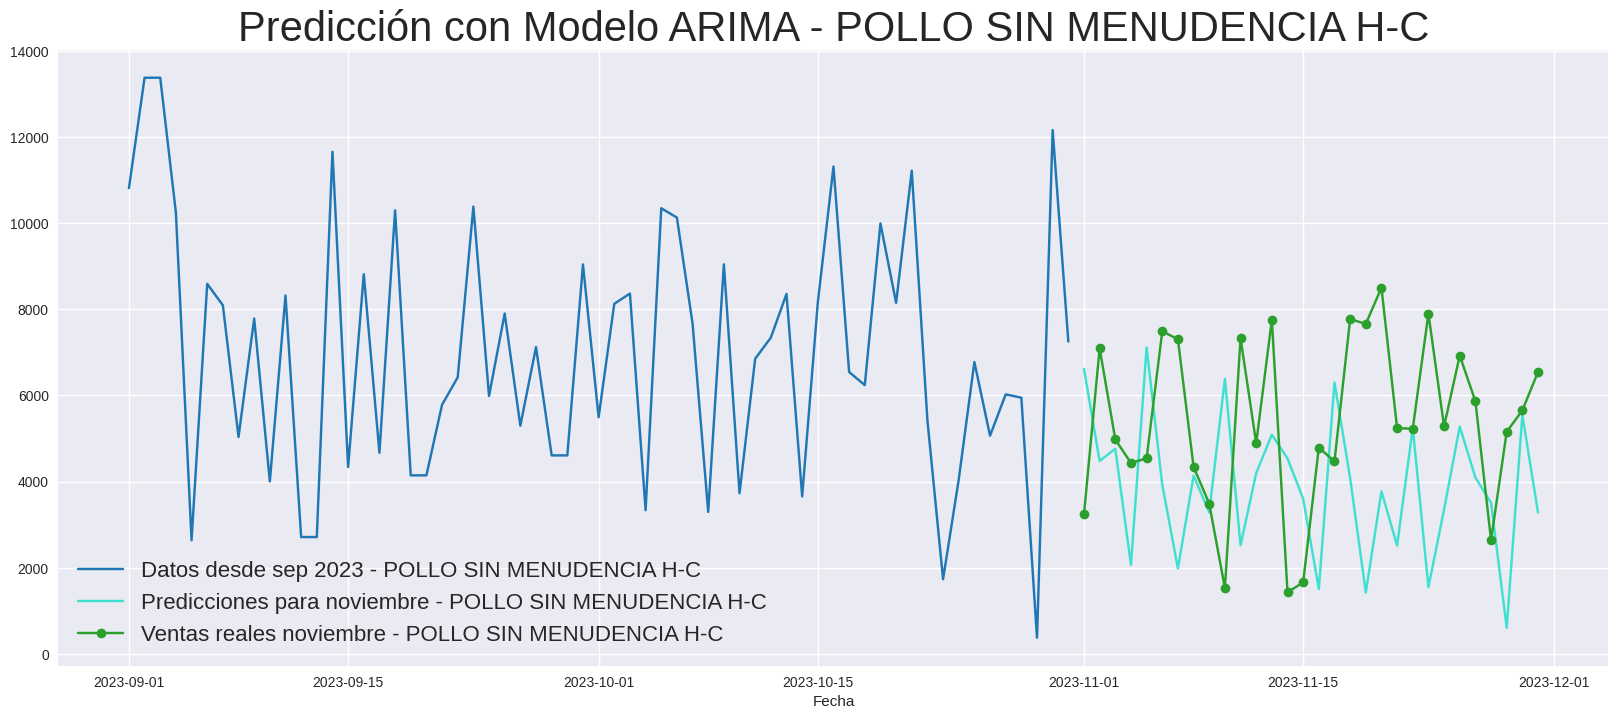

<ipython-input-217-336059ccefa9>:114: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


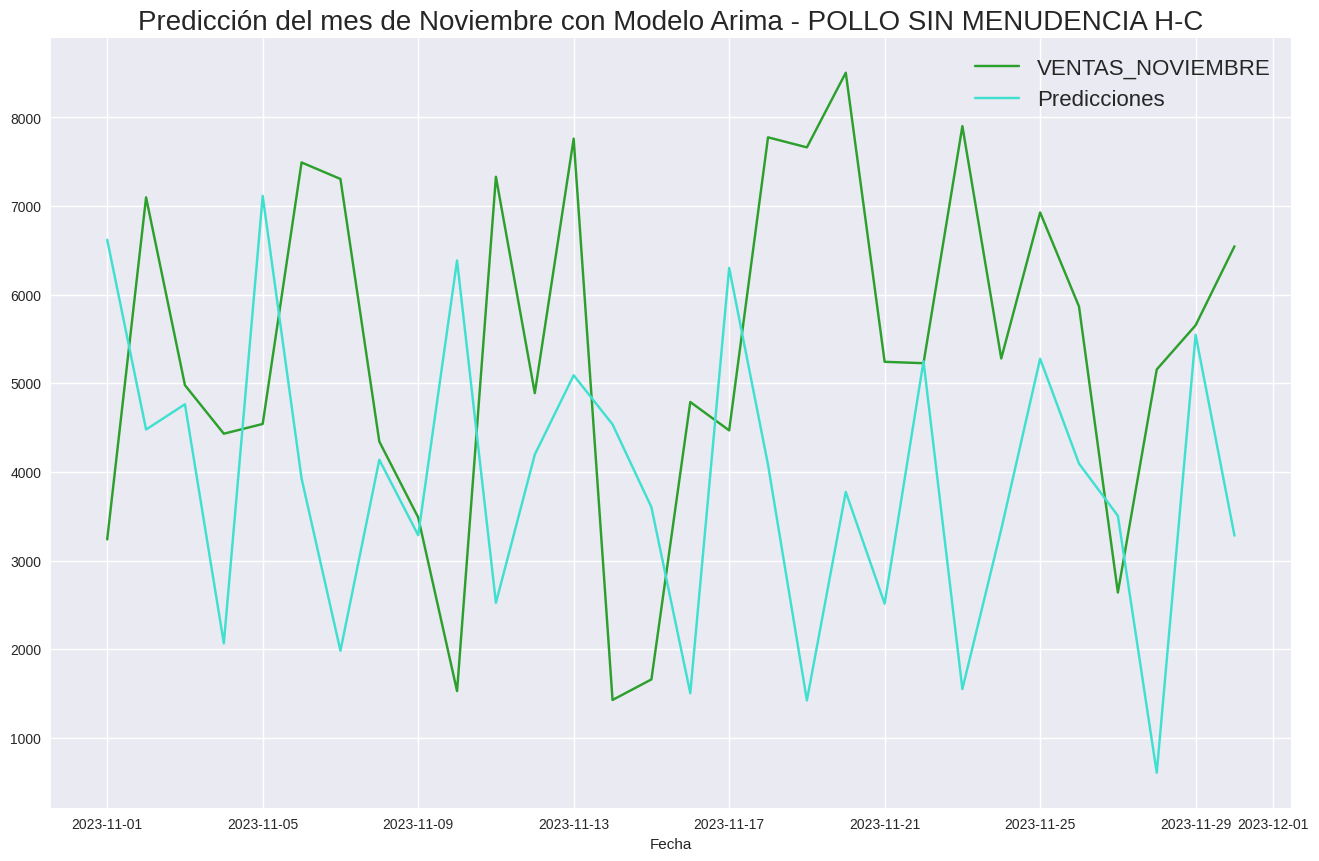

Predicciones para PIERNA MUSLO:


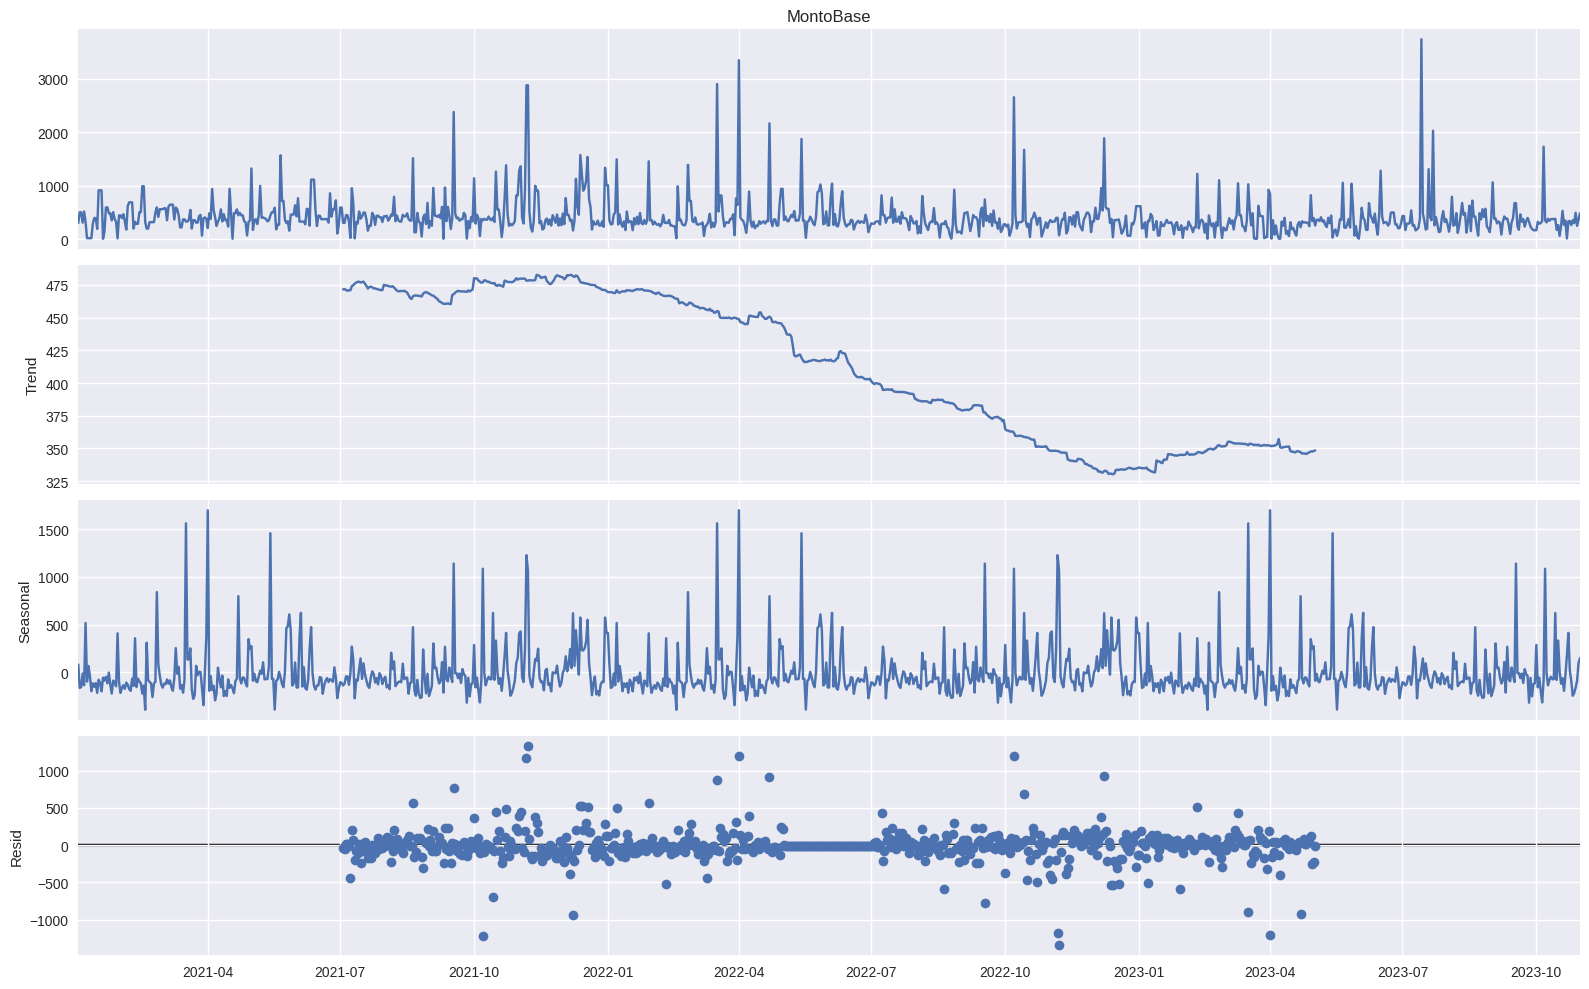

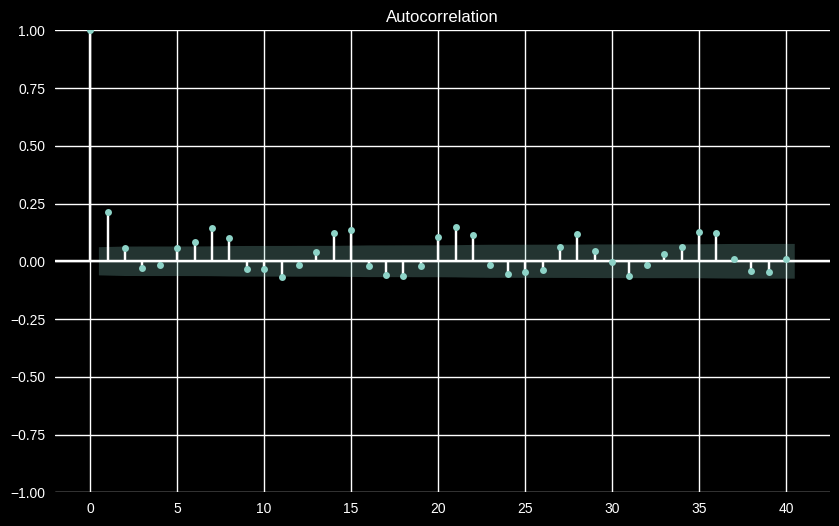

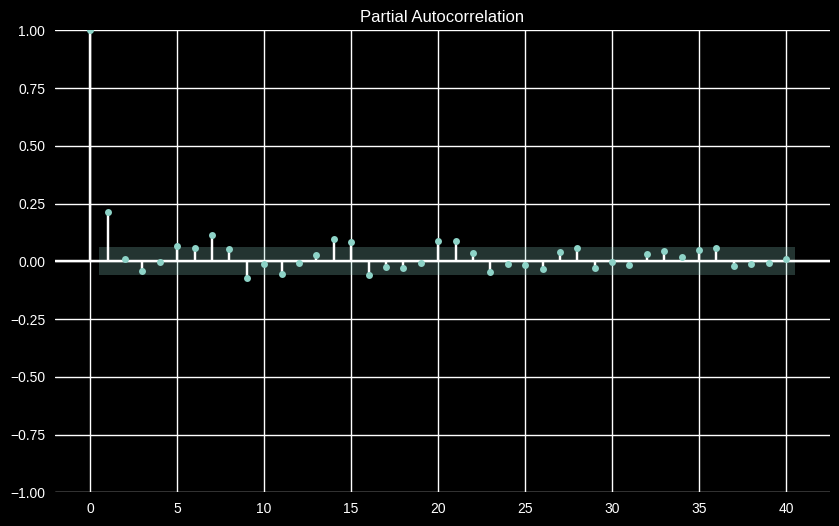

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys([

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01   265.5720
2023-10-02   450.7594
2023-10-03   325.4265
2023-10-04   364.6052
2023-10-05   287.4457
2023-10-06   380.8353
2023-10-07   367.0370
2023-10-08   314.8784
2023-10-09   344.7556
2023-10-10   290.7525
2023-10-11   316.0993
2023-10-12   356.0237
2023-10-13   268.4650
2023-10-14   427.6898
2023-10-15   343.1319
2023-10-16   376.3006
2023-10-17   312.6422
2023-10-18   353.4239
2023-10-19   256.4503
2023-10-20   303.0341
2023-10-21   350.2984
2023-10-22   345.8931
2023-10-23   372.3939
2023-10-24   354.7434
2023-10-25   270.7973
2023-10-26   434.7986
2023-10-27   327.6452
2023-10-28   372.1685
2023-10-29   295.6549
2023-10-30   364.9189
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
                 MontoBase  P-V_ARIMA_PIERNA MUSLO
FechaMovimiento                                 

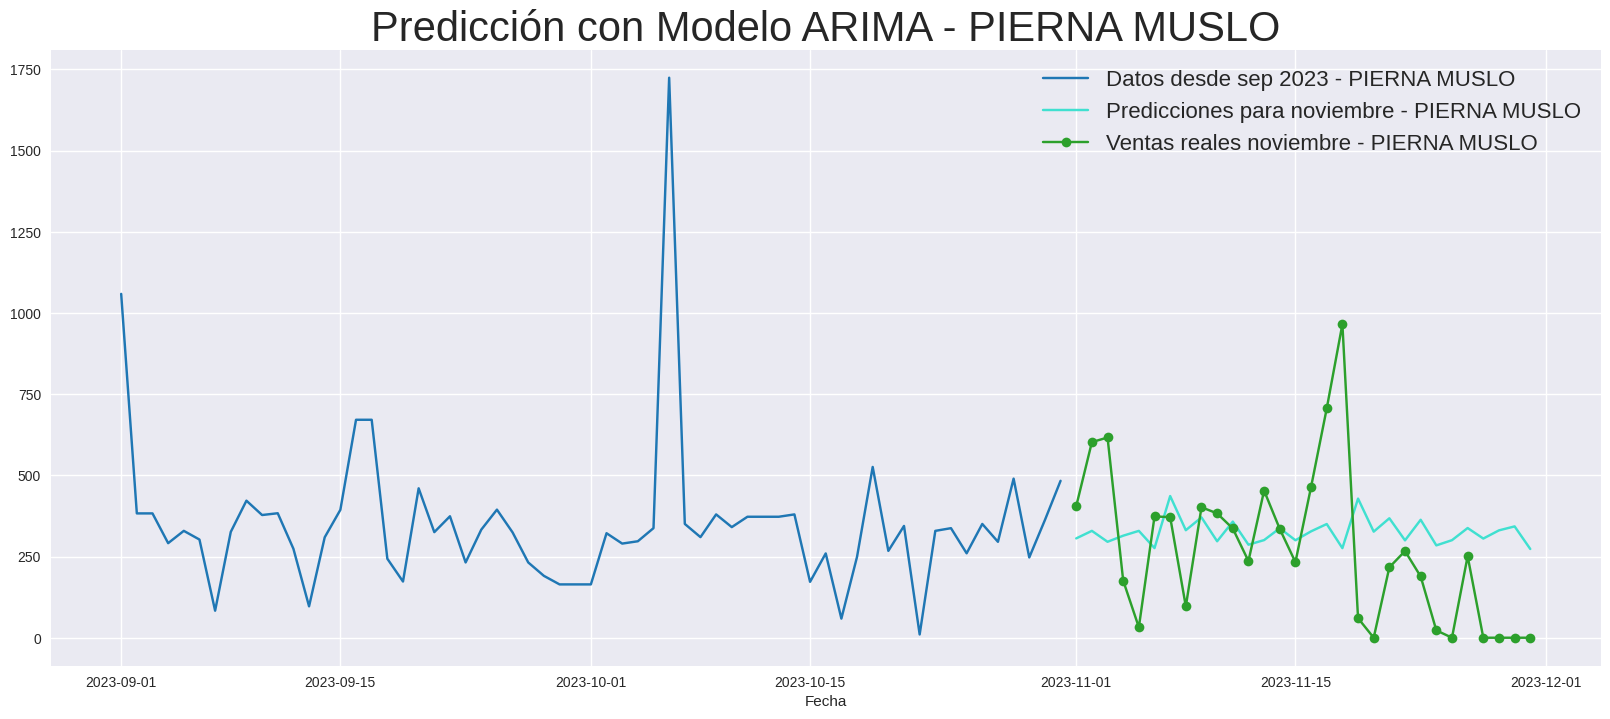

<ipython-input-217-336059ccefa9>:114: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


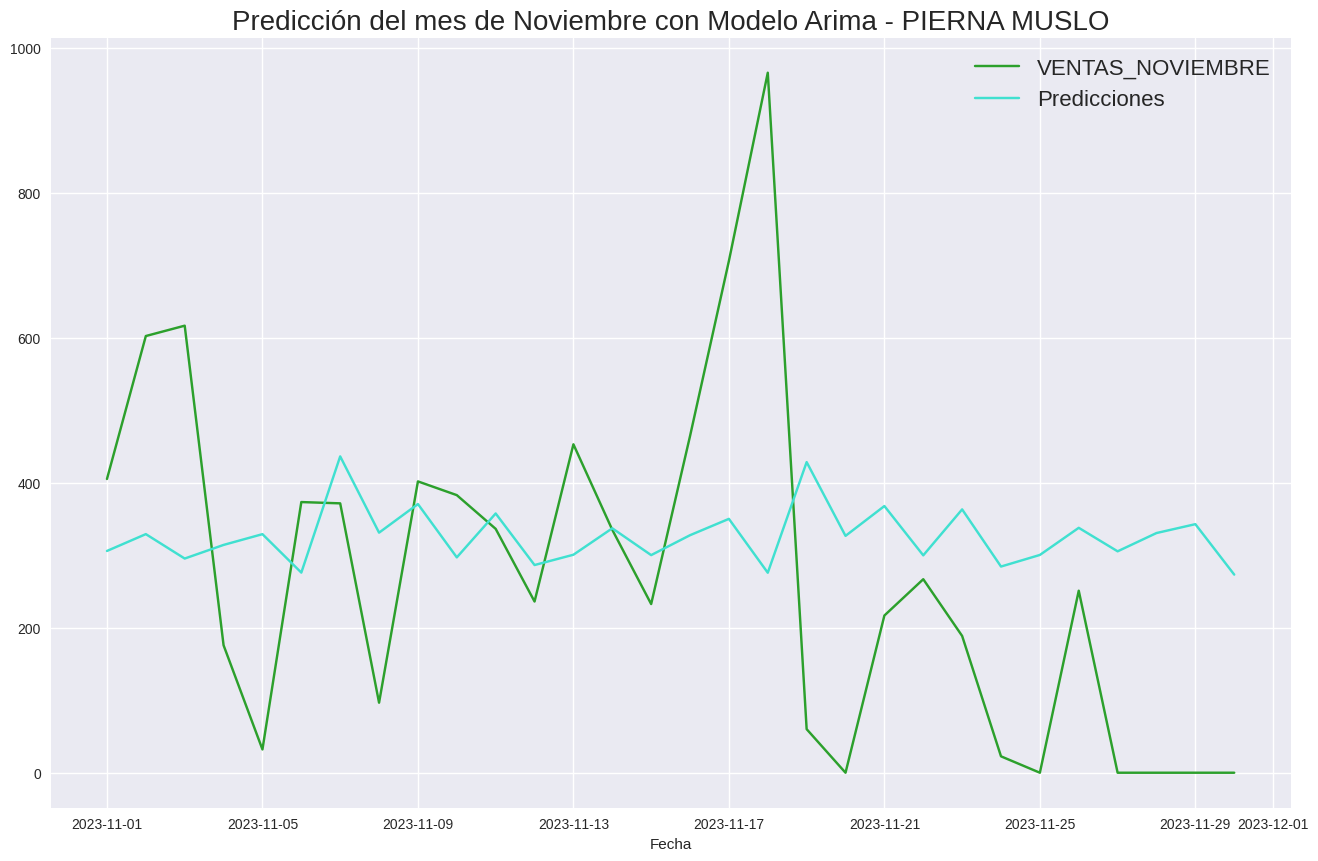

Predicciones para PECHUGA:


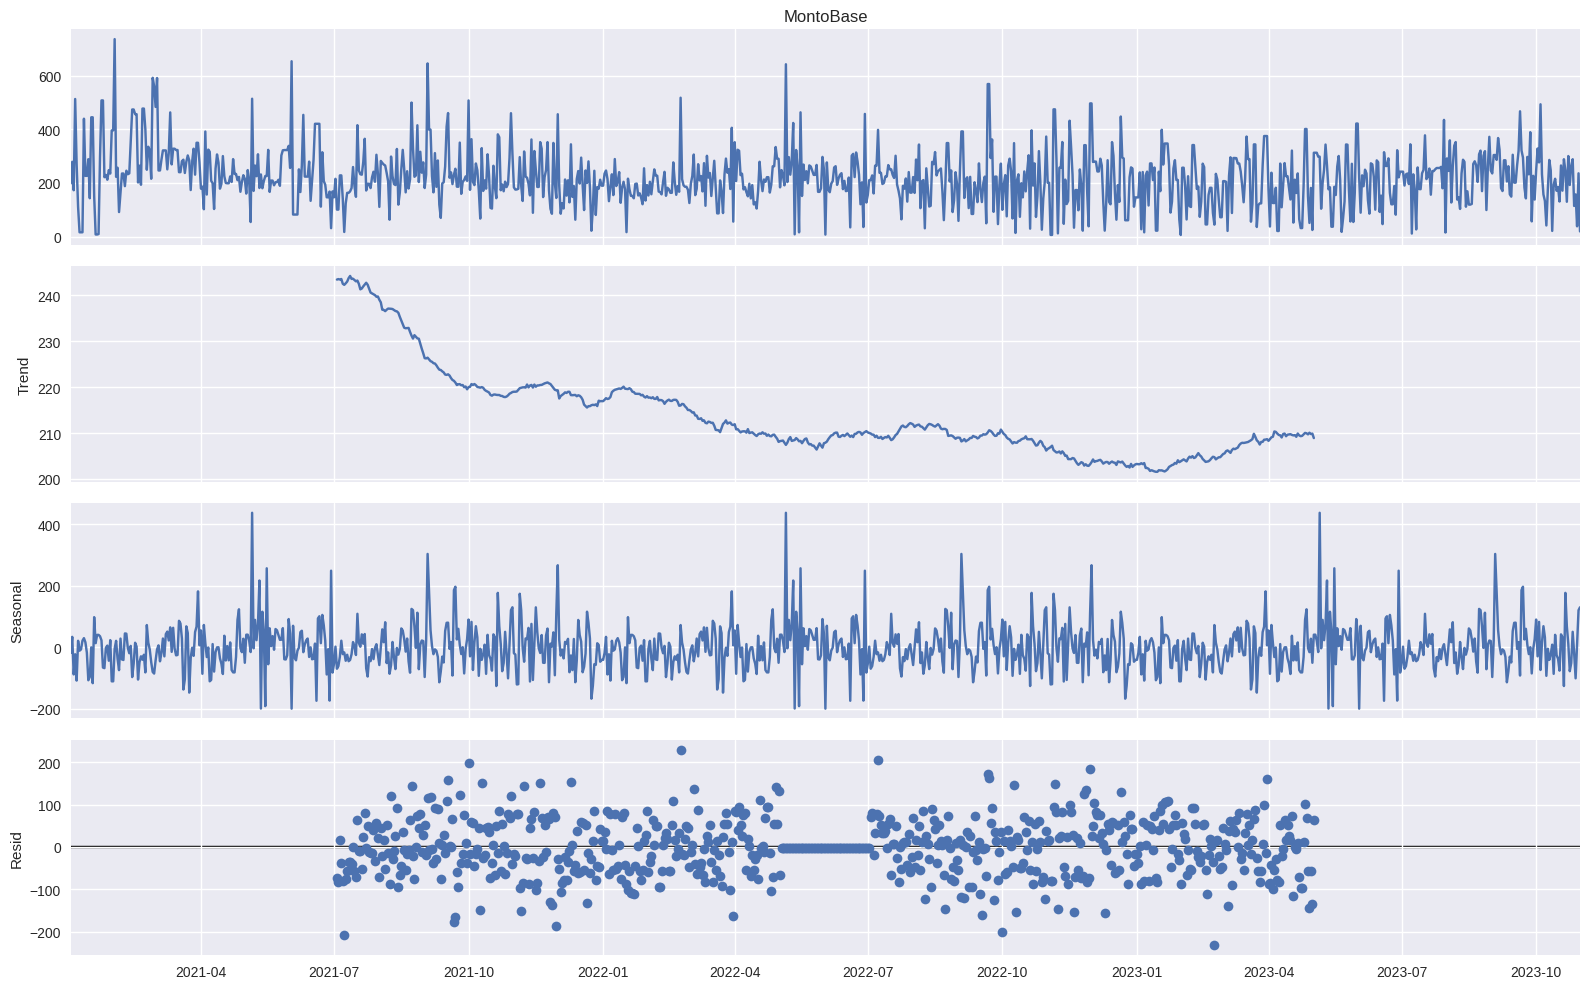

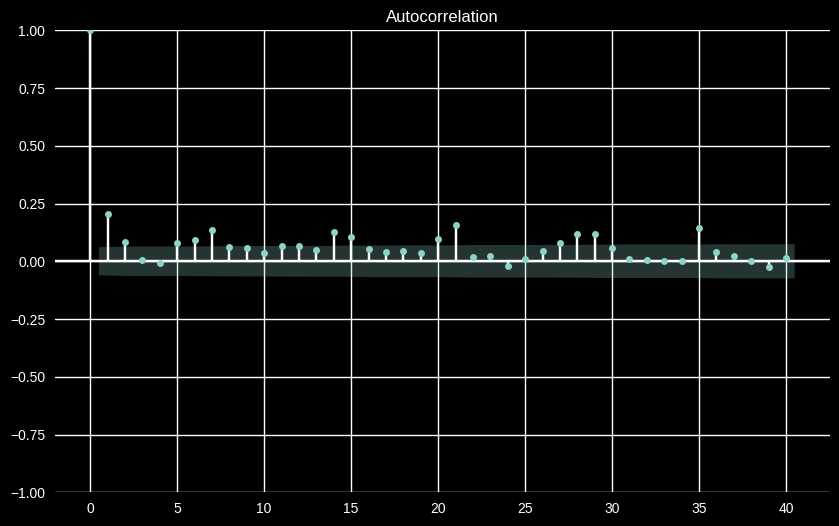

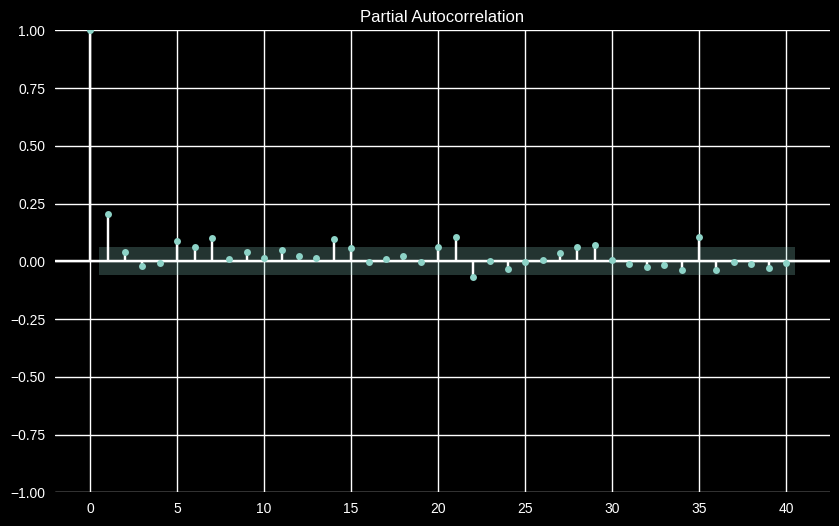

(1002, 2) (31, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-217-336059ccefa9>:96: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.

el ultimo indice_valor de los datos reales es: 1002,
se supone que deeria acabar 30 despues, pero la funcion indica: 1031 

2023-10-01   180.8933
2023-10-02   257.4627
2023-10-03   103.8869
2023-10-04   160.8862
2023-10-05   143.2157
2023-10-06   173.5982
2023-10-07   193.4823
2023-10-08   180.2112
2023-10-09   226.4766
2023-10-10   158.1276
2023-10-11   227.0908
2023-10-12   158.9959
2023-10-13   178.9182
2023-10-14   225.7076
2023-10-15   125.7775
2023-10-16   185.8015
2023-10-17   175.8943
2023-10-18   150.7565
2023-10-19   150.8717
2023-10-20   155.5811
2023-10-21   237.5279
2023-10-22   127.7241
2023-10-23   199.9026
2023-10-24   172.5219
2023-10-25   153.7125
2023-10-26   215.3294
2023-10-27   161.4973
2023-10-28   177.9827
2023-10-29   116.5752
2023-10-30   123.3036
Freq: D, Name: ARIMA Predictions PECHUGA, dtype: float64

Ventas reales y predicciones ARIMA para PECHUGA:
                 MontoBase  P-V_ARIMA_PECHUGA
FechaMovimiento                              
2023-11-01       

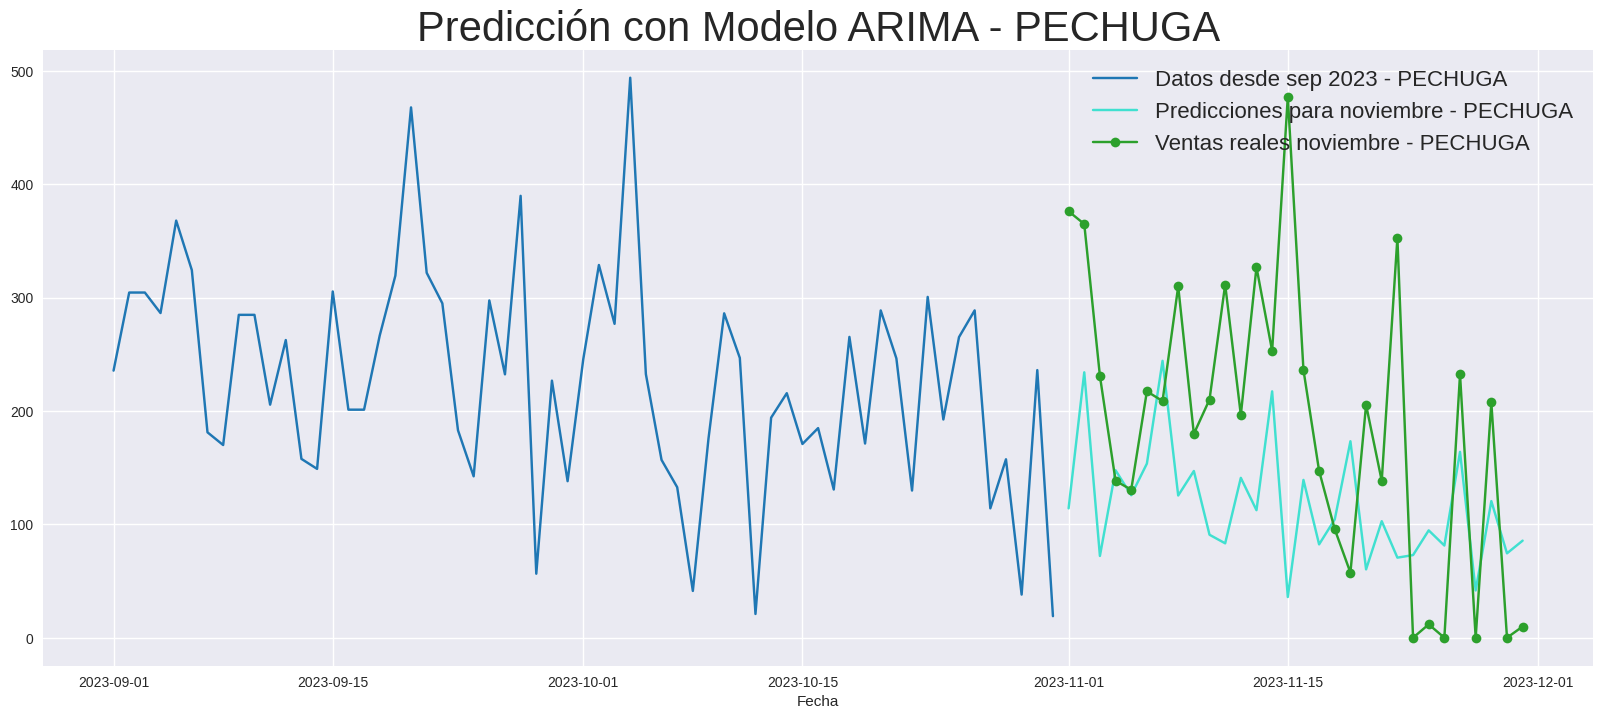

<ipython-input-217-336059ccefa9>:114: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


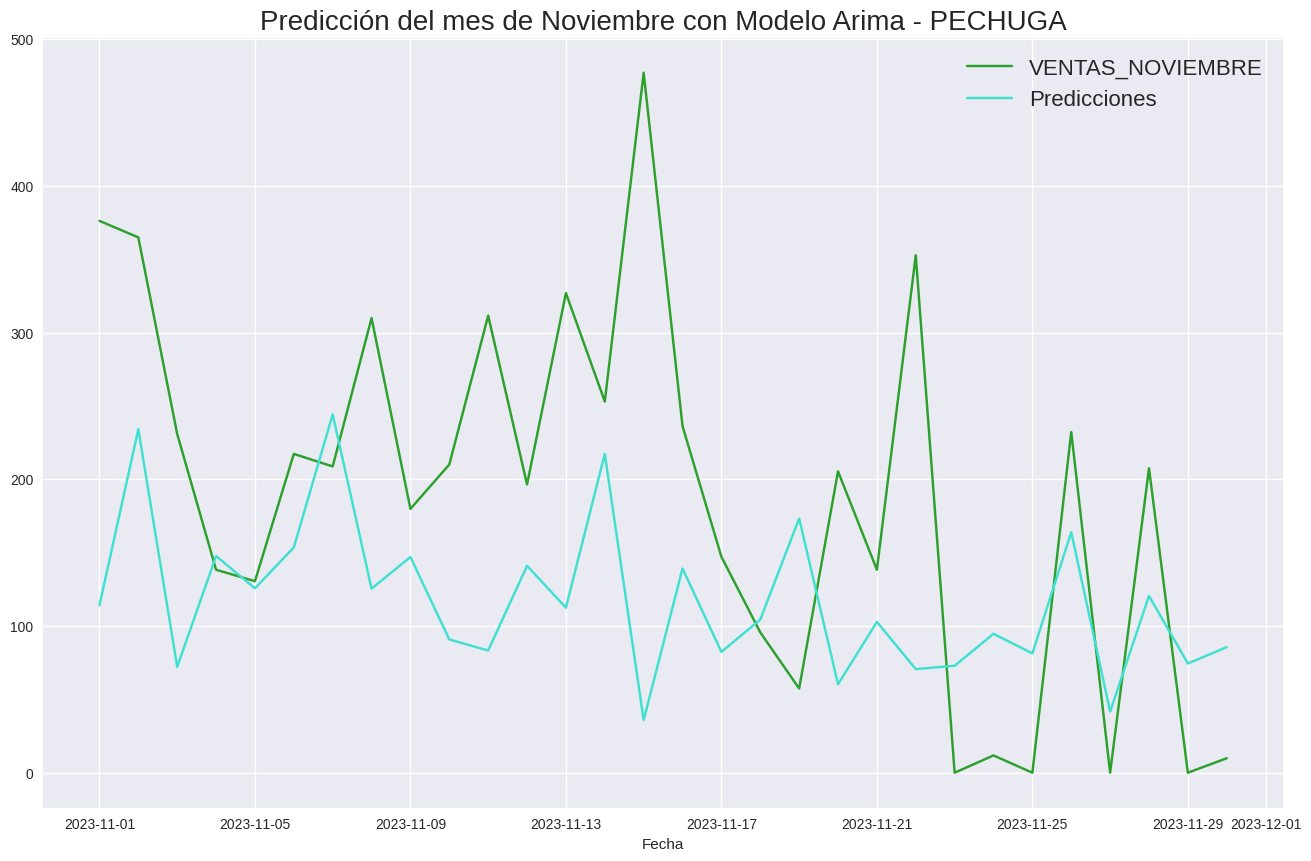

In [ ]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

contador = 0
vp, vd, vq = 0, 0, 0
vP, vD, vQ = 0, 0, 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    contador += 1
    if len(product_df_arima) >= 730:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()
    else:
        print(f"No hay suficientes datos para graficar la descomposicion estacional del producto {product}.")
    # Visualizar ACF y PACF
    plt.style.use('dark_background')
    plt.rcParams["figure.figsize"] = (10, 6)
    plot_acf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    plot_pacf(product_df_arima['MontoBase'], lags=40)
    plt.show()

    # Dividir en orden cronológico, entrenando sin el mes de octubre
    train_size_arima = int(len(product_df_arima) - 31)
    train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

    print(train_arima.shape, test_arima.shape)

    if contador == 1:
        vp, vd, vq = 3, 1, 0
        vP, vD, vQ = 3, 1, 0
    elif contador == 2:
        vp, vd, vq = 5, 1, 2
        vP, vD, vQ = 4, 1, 2
    elif contador == 3:
        vp, vd, vq = 4, 1, 0
        vP, vD, vQ = 3, 1, 0

    # # Identificar el modelo ARIMA automáticamente
    # modelo_auto = auto_arima(train_arima['MontoBase'],
    #                           start_p=0, d=1, start_q=0,
    #                           max_p=5, max_d=2, max_q=5,
    #                           start_P=0, D=1, start_Q=0,
    #                           max_P=2, max_D=1, max_Q=2,
    #                           seasonal=True, m=12, trace=True,
    #                           error_action='ignore', suppress_warnings=True, stepwise=True,
    #                           random_state=20, n_fits=50
    #                           )
    # print(modelo_auto.summary())

    # # Configurar el modelo ARIMA
    # arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
    arima_model = SARIMAX(train_arima["MontoBase"], order=(vp, vd, vq), seasonal_order=(vP, vD, vQ, 12))
    arima_result = arima_model.fit()
    arima_models[product] = arima_result  # Guardar el modelo en el diccionario

    # Hacer predicciones con ARIMA
    arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
    # Crear un índice para las predicciones de noviembre
    november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
    arima_pred.index = november_index

    print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
    print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

    # Imprimir las predicciones para el mes de noviembre
    print(arima_pred)

    # Agregar las predicciones al DataFrame original
    if product in arima_models:
        # Hacer predicciones con ARIMA para el DataFrame actual
        arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

        # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
        arima_pred_full.index = dfs_noviembre_sumados[product].index

        # Agregar la columna de predicciones ARIMA al DataFrame actual
        dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

        # Imprimir el resultado
        print(f'\nVentas reales y predicciones ARIMA para {product}:')
        print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(15))
    else:
        print(f"No hay modelo ARIMA para {product}.")

    # Visualizar las predicciones y los datos reales
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (18, 11)
    # Datos de venta desde el 1ro de septiembre de 2023
    # Convertir la cadena a un objeto datetime.date
    start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
    plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product, color = 'tab:blue')
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
    plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color='turquoise', label='Predicciones para noviembre - ' + product)
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='tab:green', label='Ventas reales noviembre - ' + product)
    plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (16, 10)
    dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"]
    plt.plot(dfs_noviembre_sumados[product].index, dfs_noviembre_sumados[product]["MontoBase"], color="tab:green" ,label="VENTAS_NOVIEMBRE")
    plt.plot(dfs_noviembre_sumados[product].index,dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"], color = 'turquoise', label="Predicciones")
    plt.title(f"Predicción del mes de Noviembre con Modelo Arima - {product}", fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('')
    plt.legend(fontsize=16)
    plt.show()

VALORES p,d,q,P,D,Q,m para los tres productos:
- Best model:  ARIMA(4,1,2)(2,1,0)[12]
- Best model:  ARIMA(5,1,0)(2,1,0)[12]
- Best model:  ARIMA(5,1,0)(2,1,0)[12]


In [ ]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.

In [ ]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 10599829.625251539
MAE is : 2718.1797780126567
R2 is : -1.739980421657981 %
------------------------------
MRSE is : 3255.737954020799
MAPE is : 61.457556600510976 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 62722.459669363496
MAE is : 202.44051485020495
R2 is : -0.1042277393274702 %
------------------------------
MRSE is : 250.44452413531323
MAPE is : 152.65588158594034 %
------------------------------
------------------------------
Días reales calculados: 24
Días omitidos: 6
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 21201.520710217905
MAE is : 110.34905897428702
R2 is : -0.32645405734230093 %
------------------------------
MRSE

TODOS ESTOS RESULTADOS EN CON TRAIN -31

**P1 - POLLO SIN MENUDENCIA H-C**
-  ARIMA(4,1,3)(2,1,0)
 - puntiagudo, con pendiente negativa, valores positivos
    - MRSE is : 3775.4430918746107
    - MAPE is : 65.54888227636867 %
___
-  ARIMA(3,1,0)(3,1,0)
  - MRSE is : 3255.737954020799
  - MAPE is : 61.457556600510976 %
___
-  ARIMA(3,1,0)(2,1,0)
  - MRSE is : 3668.319542396278
  - MAPE is : 65.91142443327132 %
- ARIMA(2,1,0)(3,1,0)
  - MRSE is : 3284.6862534515035
  - MAPE is : 61.81589287169977 %
-  ARIMA(3,1,1)(3,1,0)
  - un poco elevados
    - MRSE is : 3201.3692039069538
    - MAPE is : 81.50791379691165 %
-  ARIMA(2,1,0)(2,1,0)
  + MRSE is : 3742.337417643525
  + MAPE is : 66.52912503015034 %
-  ARIMA(3,1,3)(3,1,0)
  + MRSE is : 3455.9152620480886
  + MAPE is : 62.11367639559471 %

**P2 - PIERNA MUSLO**
-  ARIMA(5,1,0)(2,1,0)
 - VALORES NEGATIVOS
    MRSE is : 466.50062833031626
    MAPE is : 163.03974076190087 %
-  ARIMA(7,1,0)(2,1,0)
  - NEGATIVOS
    MRSE is : 421.227206899729
    MAPE is : 129.62399030090856 %
-  ARIMA(5,1,0)(3,1,0)
  - NEGATIVOS
    MRSE is : 434.39367619468044
    MAPE is : 125.5885109218673 %
-  ARIMA(5,1,0)(4,1,1)
  - Valores poco variados
  - MRSE is : 251.59402701257738
  - MAPE is : 107.66658322793315 %
-  ARIMA(6,1,0)(4,1,0)
  - pocos negativos
    MRSE is : 344.0192713475451
    MAPE is : 92.43184360007007 %
-  ARIMA(5,1,0)(5,1,0)
  - negativos
    MRSE is : 375.1319281664654
    MAPE is : 88.71509708314025 %
-  ARIMA(7,1,0)(6,1,0)
  - negativos
    MRSE is : 315.9351376784491
    MAPE is : 122.2871664314799 %
-  ARIMA(5,1,1)(4,1,0)
  + MRSE is : 274.50697749146525
  + MAPE is : 179.6472867705888 %
-  ARIMA(3,1,1)(4,1,0)
  + MRSE is : 274.8211836253777
  + MAPE is : 179.9750501788813 %
-  ARIMA(3,1,2)(4,1,0)
  + MRSE is : 274.76569333105675
  + MAPE is : 179.700290062076 %
-  ARIMA(4,1,1)(4,1,0)
  + MRSE is : 275.0533775868496
  + MAPE is : 180.14108650204477 %
-  ARIMA(4,1,2)(4,1,0)
  + MRSE is : 274.8197619006649
  + MAPE is : 179.97358463162738 %
-  ARIMA(5,1,2)(4,1,0)
  - MRSE is : 275.051560807064
  - MAPE is : 180.13826191240182 %
-  ARIMA(5,1,1)(5,1,0)
  + MRSE is : 281.38969309194977
  + MAPE is : 178.0638550300571 %
-  ARIMA(5,1,2)(5,1,0)
  + MRSE is : 281.76169359419464
  + MAPE is : 178.5019551783667 %
-  ARIMA(5,1,2)(5,1,2)
  + MRSE is : 250.73490923645957
  + MAPE is : 153.00291395509777 %
___
-  ARIMA(5,1,2)(4,1,2)
  + MRSE is : 250.44452413531323
  + MAPE is : 152.65588158594034 %
___

**P3 - PECHUGA**
- ARIMA(5,1,0)(2,1,0)
  - Un valor NEGATIVO
    - MRSE is : 156.02977947951268
    MAPE is : 97.5734234817013 %
- ARIMA(6,1,0)(2,1,0)
  - UN NEGATIVO
    - MRSE is : 151.3650464434918
    MAPE is : 96.44426178387026 %
- ARIMA(6,1,0)(2,1,1)
  + Tiende a una recta
  - MRSE is : 129.31017950729824  MAPE is : 177.94052354328412 %
- ARIMA(6,1,0)(3,1,0)
  + MRSE is : 133.59933034615892
  + MAPE is : 124.2058030490973 %
- ARIMA(6,1,1)(3,1,0)
  + MRSE is : 147.08420451060618
  + MAPE is : 222.18267402736424 %
- ARIMA(6,1,0)(4,1,0)
  - valores alejados de los picos maximos
  - MRSE is : 130.21233100522565
  - MAPE is : 133.09629677411783 %
- ARIMA(3,1,0)(3,1,0)
  - un negativo
    MRSE is : 166.59226546684846
    MAPE is : 73.27647839681461 %
- ARIMA(2,1,0)(2,1,0)
  - negativos
    MRSE is : 233.55388732478565
    MAPE is : 146.01605957248393 %
- ARIMA(4,1,1)(2,1,0)
  - MRSE is : 149.7233651957816
  + MAPE is : 235.32392736480259 %
- ARIMA(6,1,0)(6,1,0)
  + MRSE is : 128.97644341032864
  + MAPE is : 156.44209782287462 %
- ARIMA(6,1,2)(4,1,0)
  + MRSE is : 144.76420584133322
  + MAPE is : 218.37968982438133 %
___
- ARIMA(4,1,0)(3,1,0)
  + MRSE is : 145.60741983229394
  + MAPE is : 102.05563279472966 %
___
- ARIMA(4,1,0)(2,1,0)
  - NEGATIVOS
    MRSE is : 173.67128814446872
    MAPE is : 79.01364308901341 %
- ARIMA(4,1,0)(4,1,0)
  + MRSE is : 138.00779800879954
  + MAPE is : 113.34978704984893 %
  


VALORES CON TRAIN -30

**P1 - POLLO SIN MENUDENCIA H-C**
-  ARIMA(3,1,0)(3,1,0)[12]   
  - NEGATIVOS
    MRSE is : 4525.120455019221
    MAPE is : 72.13538019889972 %

**P2 - PIERNA MUSLO**
-  ARIMA(7,1,0)(2,1,0)[12]
  - NEGATIVOS
    MRSE is : 393.028659401799
    MAPE is : 107.91718212058723 %

luego - ARIMA(5,1,0)(3,1,0)[12]

**P3 - PECHUGA**
- ARIMA(6,1,0)(2,1,0)[12]
  + bien
    + MRSE is : 143.0808711537705
    + MAPE is : 116.82496616375262 %


luego - ARIMA(5,1,0)(3,1,0)[12]

# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-224-0bcf36039ac0>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


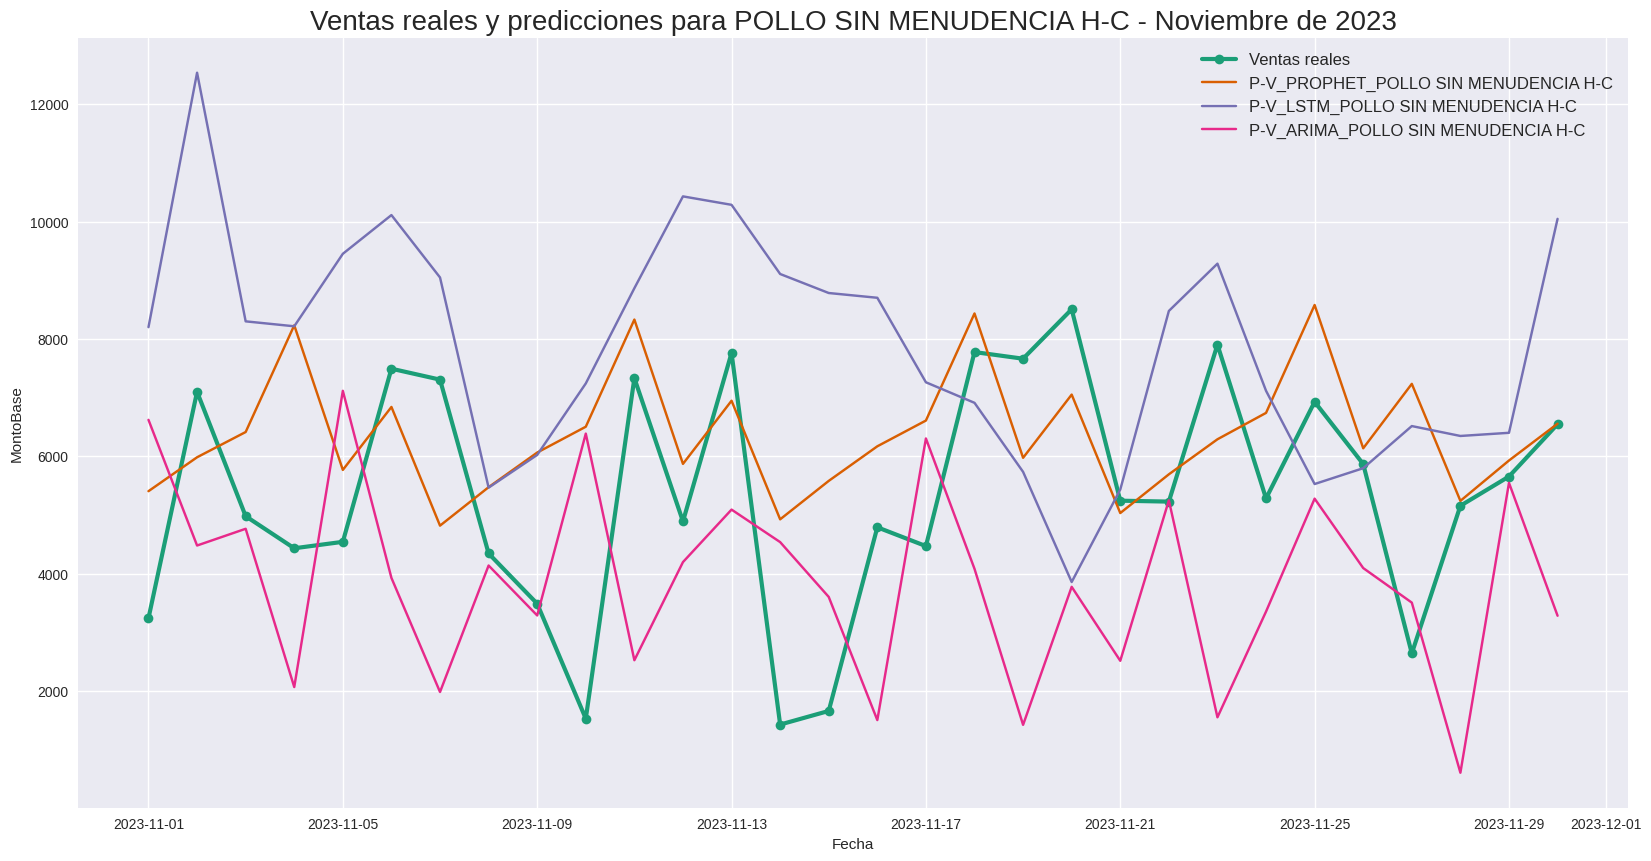

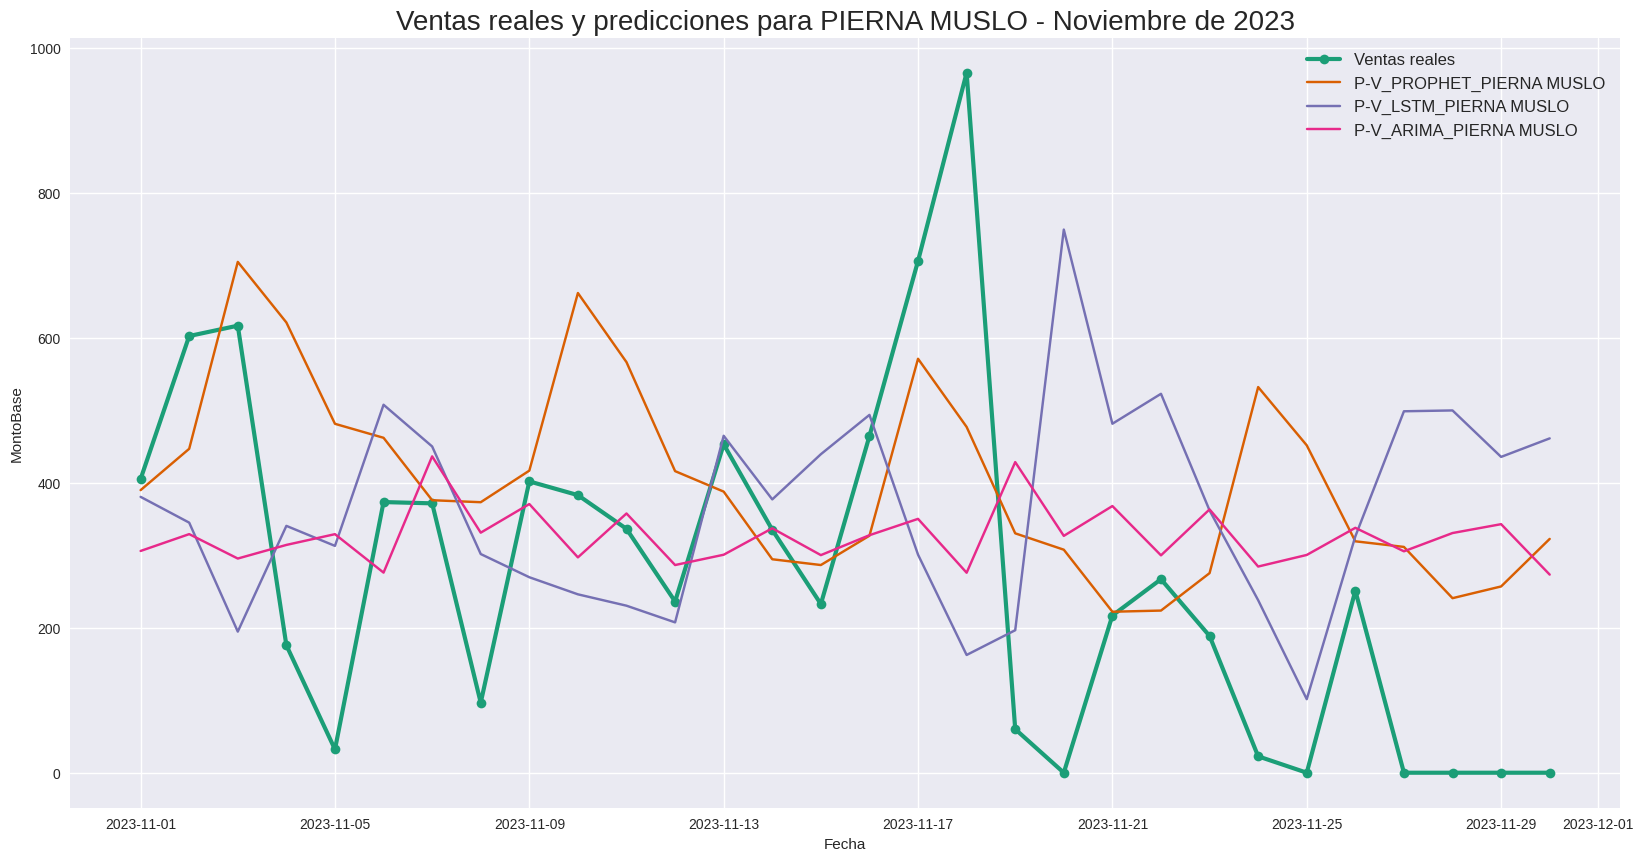

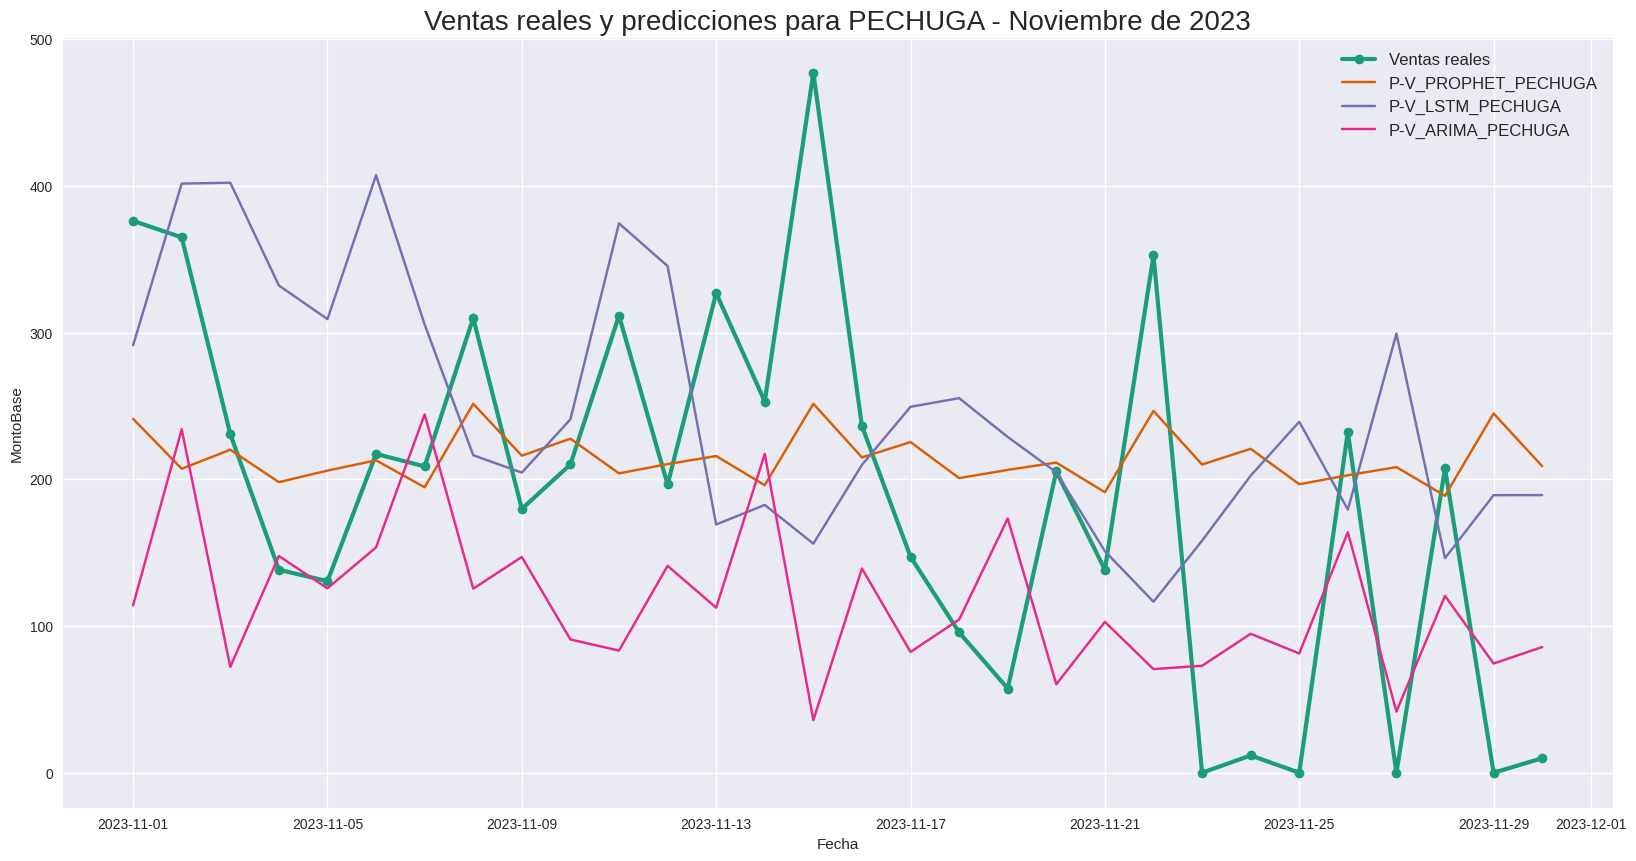

In [ ]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales', marker='o', linewidth=3)

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO SIN MENUDENCIA H-C
Modelo: PROPHET
Evaluation metric results:  
MSE is : 4475858.056691233
MAE is : 1657.2016197078437
R2 is : -0.15697741181034242 %
------------------------------
MRSE is : 2115.622380457163
MAPE is : 53.72754396009374 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 13303934.929416018
MAE is : 3070.4397097786455
R2 is : -2.438972372798549 %
------------------------------
MRSE is : 3647.455953046728
MAPE is : 92.18648401903776 %
------------------------------
------------------------------
Días reales calculados: 30
Días omitidos: 0
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 10599829.625251539
MAE is : 2718.1797780126567
R2 is : -1.739980421657981 %
------------------------------
MRSE is : 3255.737954020799
MAPE is : 61.

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():

    print(product_df)


                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  3239.2974   
2023-11-02       POLLO SIN MENUDENCIA H-C  7098.1327   
2023-11-03       POLLO SIN MENUDENCIA H-C  4978.8291   
2023-11-04       POLLO SIN MENUDENCIA H-C  4431.8618   
2023-11-05       POLLO SIN MENUDENCIA H-C  4541.8035   
2023-11-06       POLLO SIN MENUDENCIA H-C  7492.0734   
2023-11-07       POLLO SIN MENUDENCIA H-C  7305.7163   
2023-11-08       POLLO SIN MENUDENCIA H-C  4343.5560   
2023-11-09       POLLO SIN MENUDENCIA H-C  3487.1891   
2023-11-10       POLLO SIN MENUDENCIA H-C  1528.0410   
2023-11-11       POLLO SIN MENUDENCIA H-C  7330.7520   
2023-11-12       POLLO SIN MENUDENCIA H-C  4889.5888   
2023-11-13       POLLO SIN MENUDENCIA H-C  7760.8445   
2023-11-14       POLLO SIN MENUDENCIA H-C  1427.7825   
2023-11-15       POLLO SIN MENUDENCIA H-C  1659.6720   
2023-11-16       POLLO SIN MENUDENCIA H-C  4789.